In [1]:
%run -i 'cosim_import.py'
import csv

1.7.2.post294.dev0+g5e54c174
2.9.0


In [2]:
caseH = 18
%run -i 'cosim_setup_andes.py'

EVA: ts=18[H], 50000 EVs, Total Q=434.64 MWh
Online 14481, Q=361.83 MWh, SoC=0.7687
Power(MW): Pt=-39.9433, Pc=-39.9433, Pd=-0.0
Ctrl: 0=7778; 1=6703; 
EVA: Load A from Aest.csv.
Working directory: "/home/jwang175/andes/jwang/notes"
> Loaded config from file "/home/jwang175/.andes/andes.rc"
> Loaded generated Python code in "/home/jwang175/.andes/pycode".
Generated code for <PQ> is stale.
Numerical code generation (rapid incremental mode) started...


Generating code for 1 models on 6 processes.


Saved generated pycode to "/home/jwang175/.andes/pycode"
> Reloaded generated Python code of module "pycode".
Generated numerical code for 1 models in 0.3215 seconds.
Parsing input file "/home/jwang175/andes/jwang/case/ieee39_ev2.xlsx"...
Input file parsed in 0.1372 seconds.
ACEc <1> added BusFreq <BusFreq_11> linked to bus <1>
System internal structure set up in 0.0656 seconds.


In [3]:
sse0 = ev_ssm(ts=18.0, N=50000, step=1, tp=40,
             lr=0.1, lp=60, seed=2022, name="EVA")

EVA: ts=18.0[H], 50000 EVs, Total Q=434.64 MWh
Online 14481, Q=361.83 MWh, SoC=0.7687
Power(MW): Pt=-39.9433, Pc=-39.9433, Pd=-0.0
Ctrl: 0=7778; 1=6703; 


In [4]:
%run -i 'cosim_setup_dispatch.py'

-> System connectivity check results:
  No islanded bus detected.
  System is interconnected.
  Each island has a slack bus correctly defined and enabled.

-> Power flow calculation
           Numba: On
   Sparse solver: KLU
 Solution method: NR method
Numba compilation initiated with caching.
Power flow initialized in 0.1263 seconds.
0: |F(x)| = 7.561249598
1: |F(x)| = 2.917108301
2: |F(x)| = 0.1313043343
3: |F(x)| = 0.0003572409148
4: |F(x)| = 4.286928146e-09
Converged in 5 iterations in 0.0154 seconds.
Power flow results are consistent. Conversion is successful.


Restricted license - for non-production use only - expires 2023-10-25


-> System connectivity check results:
  No islanded bus detected.
  System is interconnected.
  Each island has a slack bus correctly defined and enabled.

-> Power flow calculation
           Numba: On
   Sparse solver: KLU
 Solution method: NR method
Numba compilation initiated with caching.
Power flow initialized in 0.0119 seconds.
0: |F(x)| = 7.561249598
1: |F(x)| = 2.917108301
2: |F(x)| = 0.1313043343
3: |F(x)| = 0.0003572409148
4: |F(x)| = 4.286928146e-09
Converged in 5 iterations in 0.0127 seconds.
Power flow results are consistent. Conversion is successful.
GSF is consistent.
RTED GB model is loaded.
RTED removed: ['rampu', 'rampd']
RTED limited: sfru, sfrd
RTED: total cost=4910.307


pp cost=2224.8754288341006, gb cost=4910.307428177317


In [5]:
%run -i 'cosim_linktable.py'

# Change ``rru``, ``rrd``, ``rsfr``, ``t_total`` for necessary.
t_total = 3600

rru, rrd, rsfr = 1.0, 1.0, 0.04

# Define functions and constants used in loop
%run -i 'cosim_const.py'

In [6]:
pgf = pd.read_csv('cosim_18_F_pg.csv')
pgs = pd.read_csv('cosim_18_S_pg.csv')
pgh = pd.read_csv('cosim_18_H_pg.csv')
agcf = pd.read_csv('cosim_18_F_agcm.csv')
agcs = pd.read_csv('cosim_18_S_agcm.csv')
agch = pd.read_csv('cosim_18_H_agcm.csv')
outf = pd.read_csv('cosim_18_F_out.csv')
outs = pd.read_csv('cosim_18_S_out.csv')
outh = pd.read_csv('cosim_18_H_out.csv')
outf['fd'] = outf['freq'] - ssa.config.freq
outs['fd'] = outs['freq'] - ssa.config.freq
outh['fd'] = outh['freq'] - ssa.config.freq

evf = pd.read_csv('cosim_18_F_sse.csv')
evs = pd.read_csv('cosim_18_S_sse.csv')
evh = pd.read_csv('cosim_18_H_sse.csv')
evdf = pd.read_csv('cosim_18_F_evdata.csv')
evds = pd.read_csv('cosim_18_S_evdata.csv')
evdh = pd.read_csv('cosim_18_H_evdata.csv')

sfrf = pd.read_csv('cosim_18_F_sfr.csv')
sfrs = pd.read_csv('cosim_18_S_sfr.csv')
sfrh = pd.read_csv('cosim_18_H_sfr.csv')

evagcf = pd.read_csv('cosim_18_F_evagc.csv').T
evsocf = pd.read_csv('cosim_18_F_evsoc.csv').T
evsocf.sort_values(by=['0'], axis=1, inplace=True)
evagcs = pd.read_csv('cosim_18_S_evagc.csv').T
evsocs = pd.read_csv('cosim_18_S_evsoc.csv').T
evsocs.sort_values(by=['0'], axis=1, inplace=True)
evagch = pd.read_csv('cosim_18_H_evagc.csv').T
evsoch = pd.read_csv('cosim_18_H_evsoc.csv').T
evsoch.sort_values(by=['0'], axis=1, inplace=True)

reader = csv.reader(open('cosim_18_F_rted.csv', 'r'))
rted_res = {}
for row in reader:
   k, v = row
   rted_res[k] = v

<AxesSubplot:xlabel='Time'>

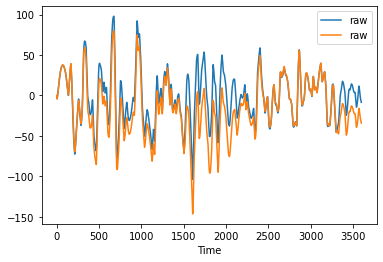

In [7]:
ACE_integral = 0
ACE_raw = 0
raw = -1 * np.ones((3600, 3))
for end_time in range(3600):
    acep = outs['ACE'][(outs['Time'] >= end_time-0.03)&(outs['Time'] <= end_time)].mean()
    ACE_integral += acep
    ACE_raw = -(Kp*acep + Ki*ACE_integral)
    raw[end_time] = [end_time, ACE_raw, ACE_integral]
raws = pd.DataFrame(raw, columns=['Time', 'raw', 'itg'])
    
ACE_integral = 0
ACE_raw = 0
raw = -1 * np.ones((3600, 3))
for end_time in range(3600):
    acep = outf['ACE'][(outf['Time'] >= end_time-0.03)&(outf['Time'] <= end_time)].mean()
    ACE_integral += acep
    ACE_raw = -(Kp*acep + Ki*ACE_integral)
    raw[end_time] = [end_time, ACE_raw, ACE_integral]
rawf = pd.DataFrame(raw, columns=['Time', 'raw', 'itg'])

fig, ax = plt.subplots()
raws.plot(x='Time', y='raw', fig=fig, ax=ax)
rawf.plot(x='Time', y='raw', fig=fig, ax=ax)

In [8]:
# fig, ax = plt.subplots()
# outs.plot(x='Time', y='ACE', fig=fig, ax=ax)
# outf.plot(x='Time', y='ACE', fig=fig, ax=ax)

In [9]:
import matplotlib.font_manager

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'serif' not found because none of the following families were found: Times


ANDES total load is: 58.564 p.u.


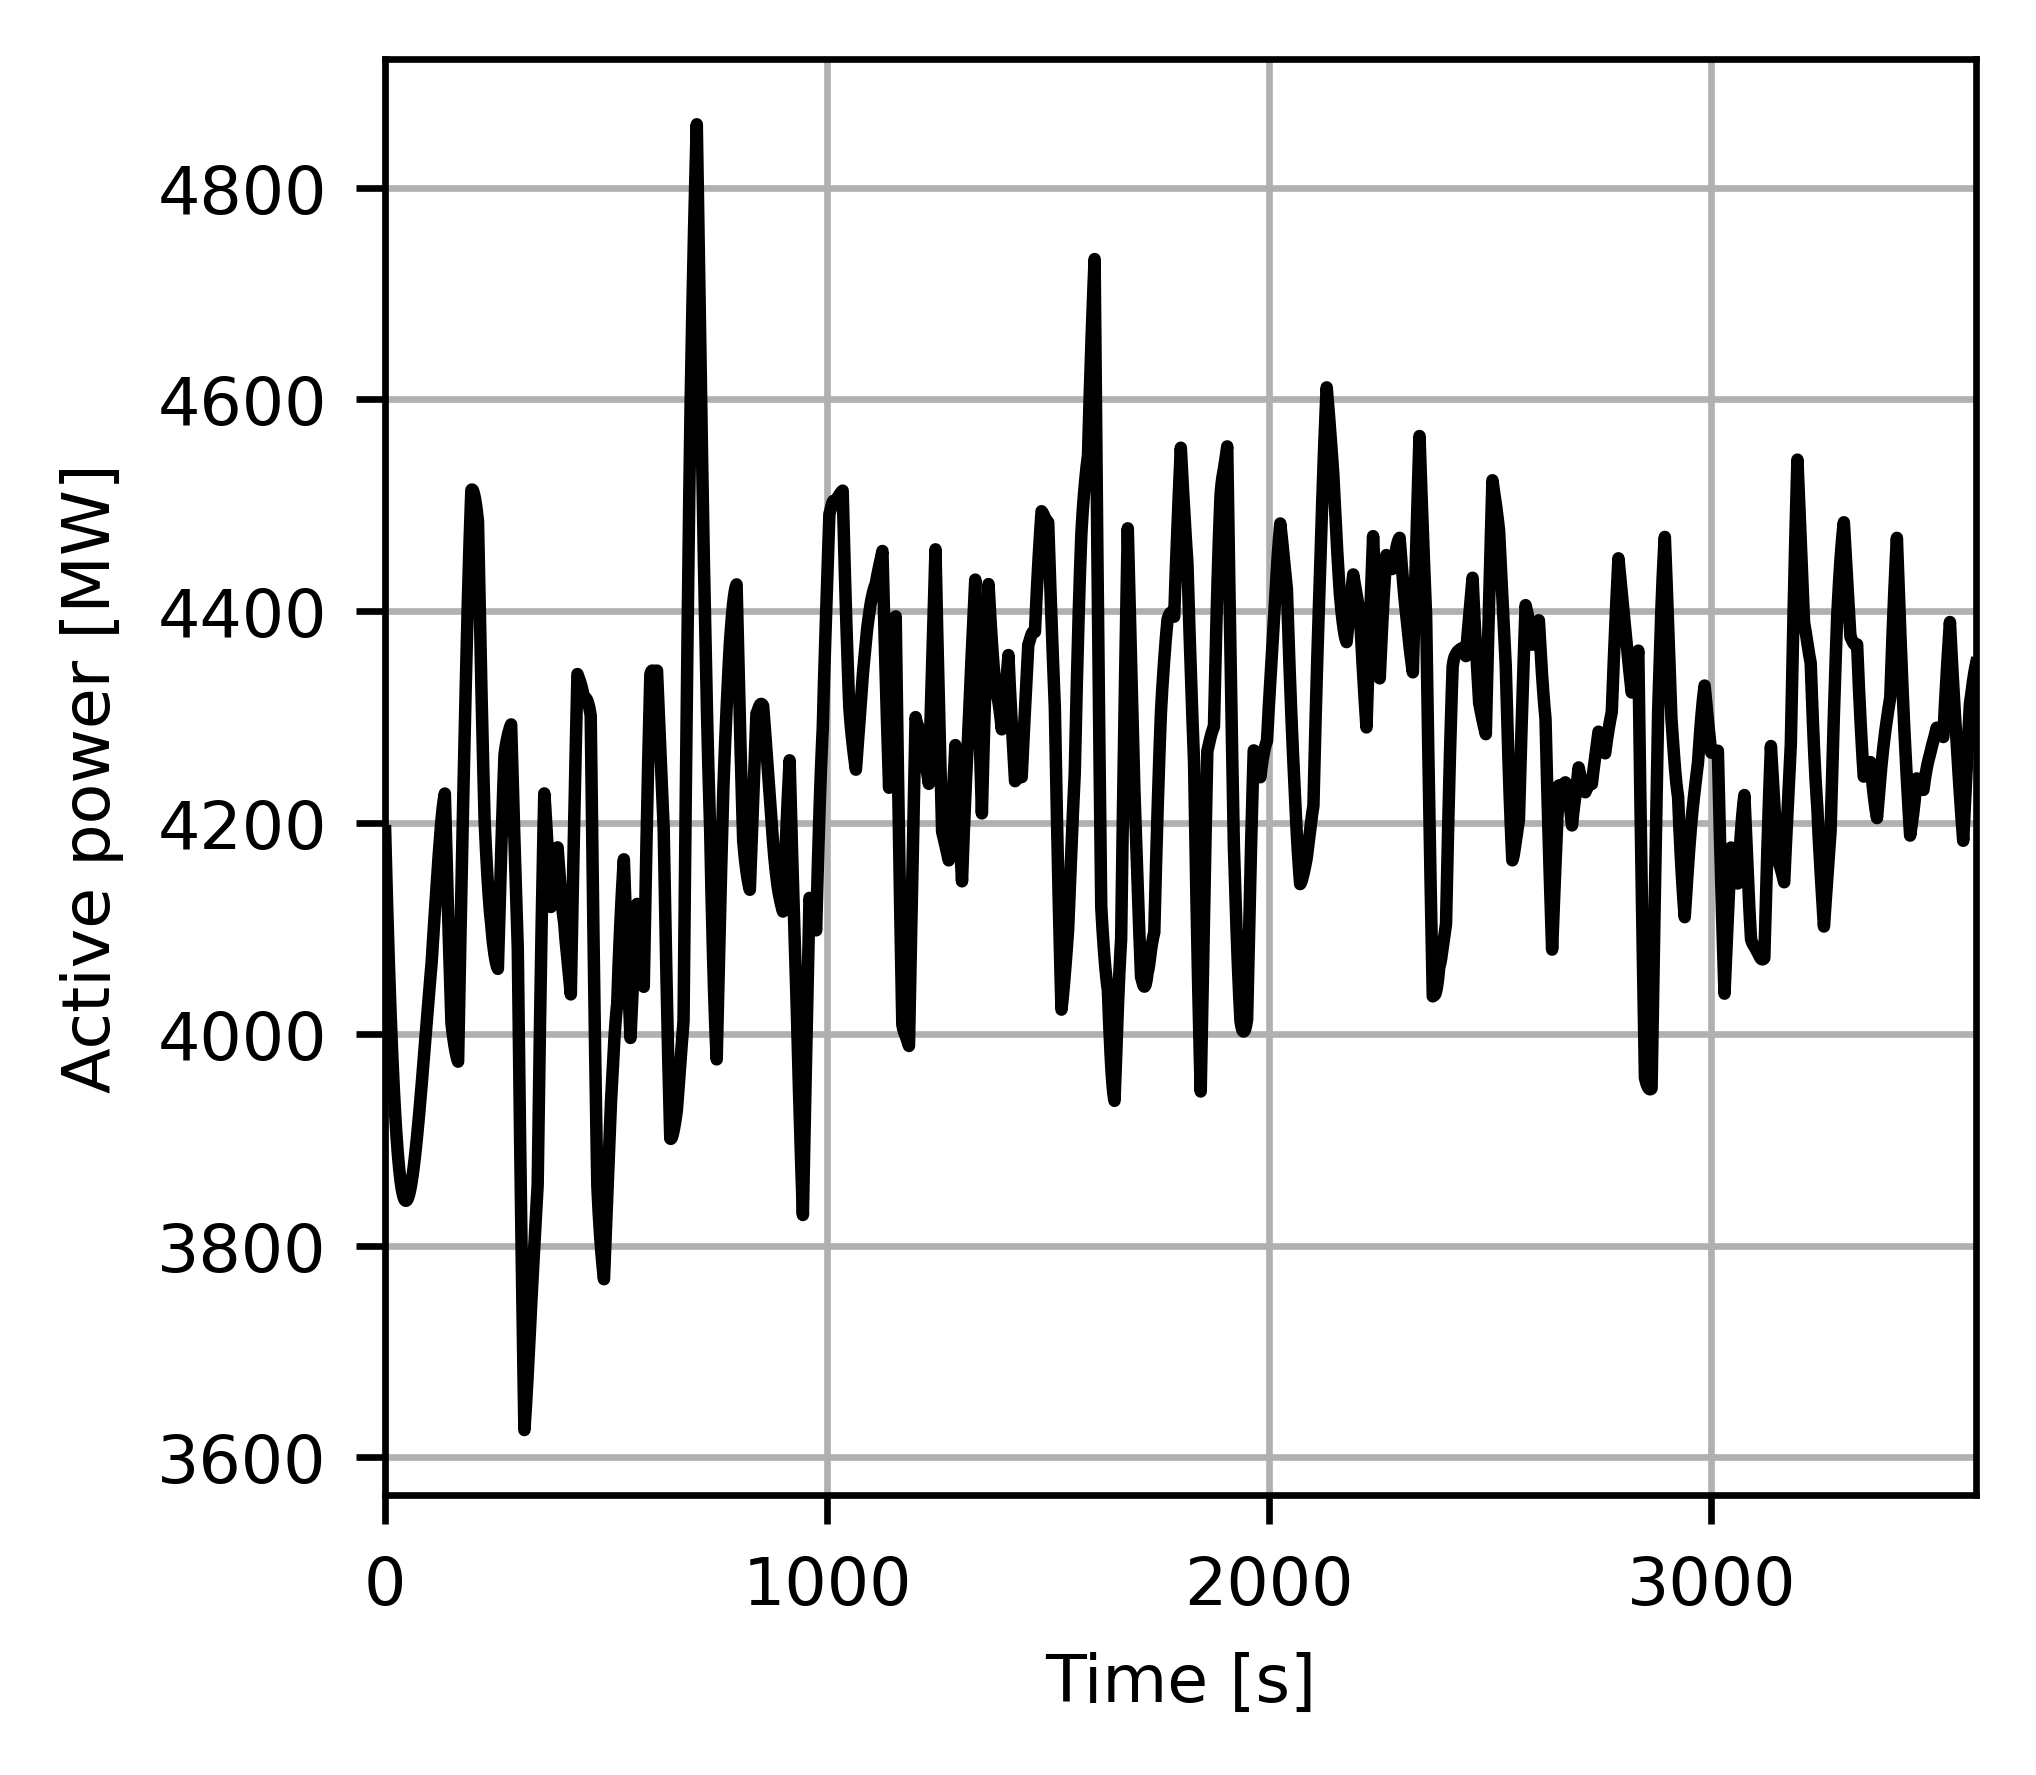

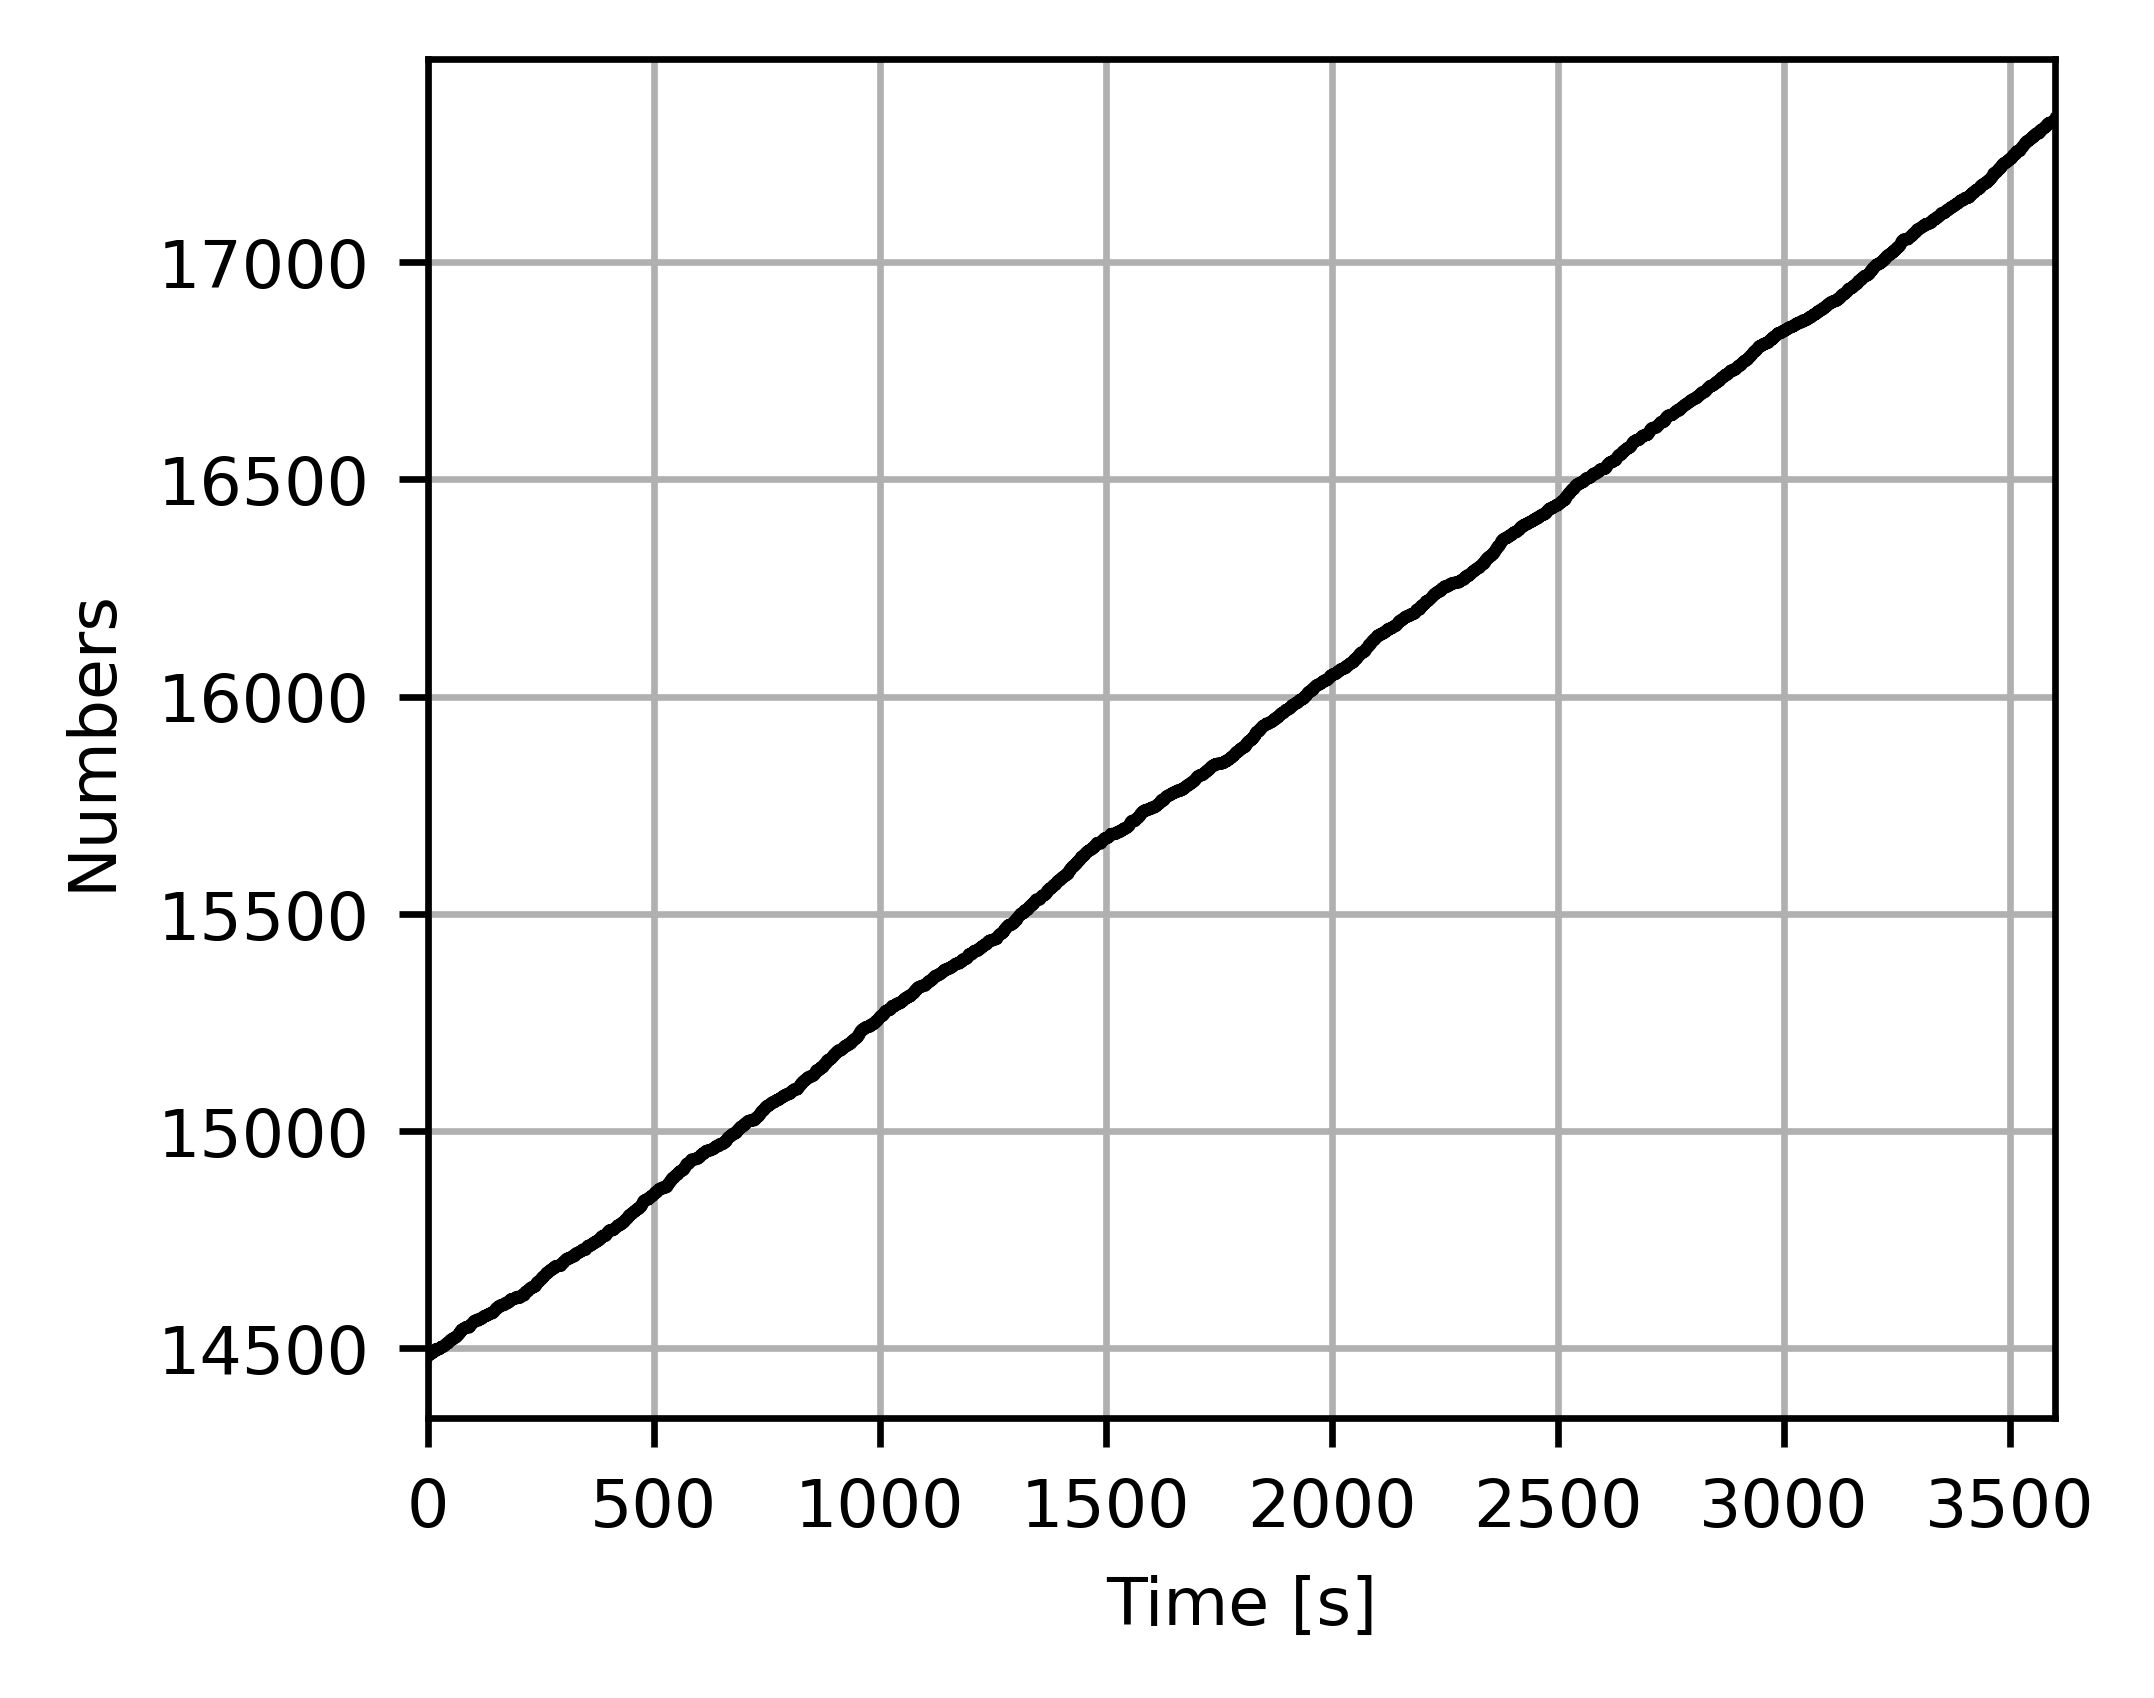

In [10]:
# --- read load from ssa ---
ptotal = ssa.PQ.as_df()['p0'].sum()
print('ANDES total load is:',ptotal.round(4),'p.u.')

# --- scale load curve ---
ddata_path = '/case/dsyn.csv'
ddata = dir_path + ddata_path
d_syn = pd.read_csv(ddata)

# the coefficient can be adjusted to fit the case
if caseH == 10:
    d_syn['sload'] = 0.8*(d_syn['ha10'] - d_syn['ha10'].min()) / d_syn['ha10'].min() + 0.7
if caseH == 18:
    d_syn['sload'] = 0.8*(d_syn['ha18'] - d_syn['ha18'].min()) / d_syn['ha18'].min() + 0.7

# extensify load fluctuation
avg = d_syn['sload'].rolling(50).mean()
d_syn['sload'] = 15 * (d_syn['sload'] - avg) + avg
d_syn['sload'] *= ptotal * ssa.config.mva

# calculate expected load
step = 300
d_exp = d_syn.groupby(d_syn.index // step).mean().copy()
d_exp['time'] = range(0,3600,300)

# align starting point of load with starting point of dispatch results
d_syn['sload'][0] = d_exp['sload'].iloc[0]
d_syn['sload'][1:100] = None
d_syn['sload'] = d_syn['sload'].interpolate(method='polynomial', order=3)

plt.style.use('ieee')
# --- plot load curve ---
fig_load, ax_load = plt.subplots(figsize=(3.5, 3))
ax_load.plot(d_syn['time'], d_syn['sload'], linestyle='-')
ax_load.set_xlim([0, 3600])
ax_load.set_ylabel('Active power [MW]')
ax_load.set_xlabel('Time [s]')
ax_load.grid()
plt.tight_layout()
fig_load.savefig("load_curve.png", bbox_inches="tight")

plt.style.use('ieee')
fig, ax = plt.subplots(1, 1, figsize=(3.5, 3))

ax.plot(3600*(np.array(evs.time)-18), evs['ne'])
ax.set_xlim([0, 3600])
ax.set_xlabel('Time [s]')
ax.set_ylabel('Numbers')
ax.grid()

In [11]:
noagcev = evagcf.abs().sum() == 0
noagcev = noagcev[noagcev].index
noagcev

Int64Index([   9,   14,   19,   23,   29,   32,   47,   58,   64,   67,
            ...
            1577, 1582, 1584, 1585, 1587, 1588, 1590, 1591, 1593, 1594],
           dtype='int64', length=198)

/home/jwang175/mambaforge/envs/andes/lib/python3.9/site-packages/pandas/core/indexes/base.py:5055: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result = getitem(key)
findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'serif' not found because none of the following families were found: Times


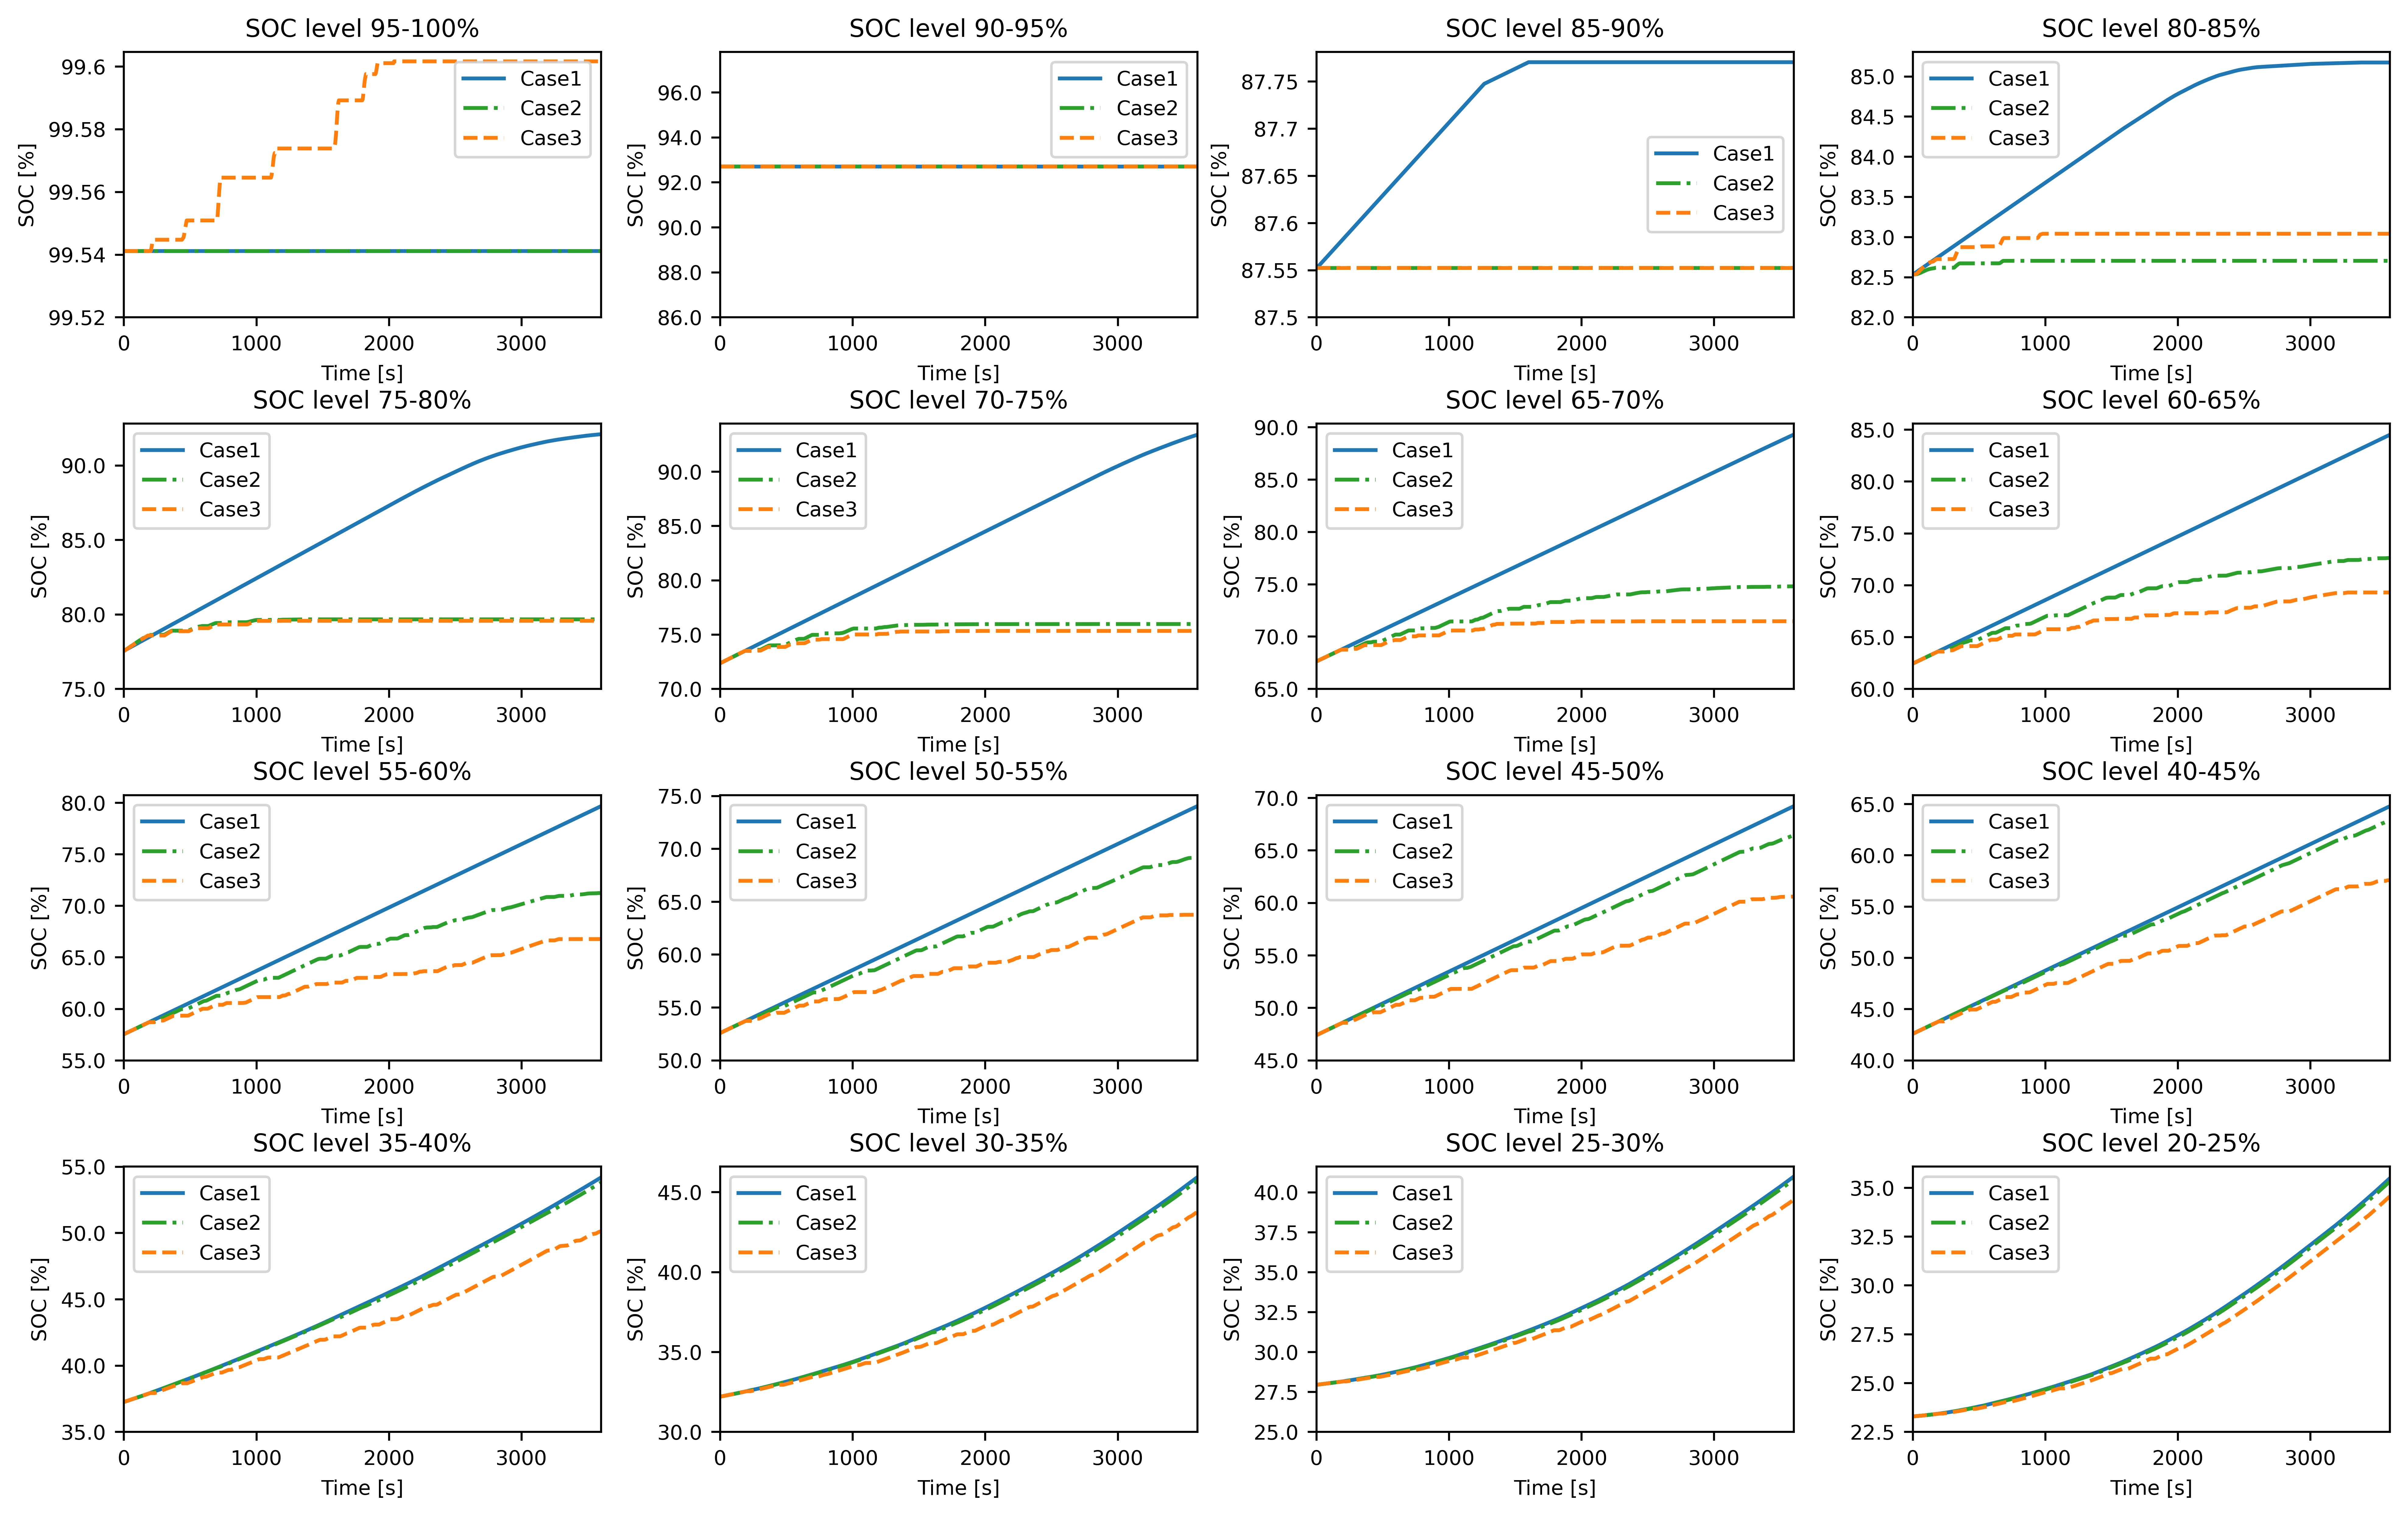

In [12]:
col_index = []
for k in range(0, 16):
    col_index = col_index + [list(np.array(range(0, 100)) + 100*k)]
col = []
for c in col_index:
    col = col + [list(evsocf.columns[[c]].values)]

fig, ax = plt.subplots(4, 4, figsize=(16, 10))
plt.subplots_adjust(left=None, bottom=None, right=None,
                    top=None, wspace=0.25, hspace=0.4)

for i in range(4):
    for j in range(4):
        idx = 15 - (4*i + j)
        ax[i, j].plot(range(3600), evsocs[col[idx]].mean(axis=1), linestyle='-', color='tab:blue', label=f'Case1')
        ax[i, j].plot(range(3600), evsoch[col[idx]].mean(axis=1), linestyle='-.', color='tab:green', label=f'Case2')
        ax[i, j].plot(range(3600), evsocf[col[idx]].mean(axis=1), linestyle='--', color='tab:orange', label=f'Case3')
        ax[i, j].legend()
        ax[i, j].set_xlim([0, 3600])
        ax[i, j].set_xlabel('Time [s]')
        ax[i, j].set_ylabel('SOC [%]')
        yticks = list(ax[i, j].get_yticks())
        ax[i, j].set_yticks(yticks[0:-1], [np.round(ytk*100, 4) for ytk in yticks[0:-1]])
        ax[i, j].set_title(f'SOC level {idx*5+20}-{idx*5+25}%')
#         ax[i, j].set_ylim([0.58, 1.02])

In [13]:
# TODO: band plot

In [14]:
epsilon = 18
k = 10 * ssa.ACEc.bias.v / epsilon / epsilon # mHz
length = 60

outscp = outs.copy()
outscp['Time'] = outscp['Time'] / length
outscp['Time'] = outscp['Time'].astype(int)
outscp = outscp.groupby('Time').mean()
outscp['prod'] = 100* (2 - k * outscp['ACE'] * outscp['fd'])

outhcp = outh.copy()
outhcp['Time'] = outhcp['Time'] / length
outhcp['Time'] = outhcp['Time'].astype(int)
outhcp = outhcp.groupby('Time').mean()
outhcp['prod'] = 100* (2 - k * outhcp['ACE'] * outhcp['fd'])

outfcp = outf.copy()
outfcp['Time'] = outfcp['Time'] / length
outfcp['Time'] = outfcp['Time'].astype(int)
outfcp = outfcp.groupby('Time').mean()
outfcp['prod'] = 100* (2 - k * outfcp['ACE'] * outfcp['fd'])

print(f"case1={outscp['prod'].mean()}, case2={outhcp['prod'].mean()}, case3={outfcp['prod'].mean()}")

# fig, ax = plt.subplots(figsize=(3.5, 3))
# outscp.plot(y='prod', kind='kde', color='tab:blue', linestyle='-',
#             legend=False, linewidth=1, fig=fig, ax=ax, label='Case1')
# outhcp.plot(y='prod', kind='kde', color='tab:green', linestyle='-',
#             legend=False, linewidth=1, fig=fig, ax=ax, label='Case2')
# outfcp.plot(y='prod', kind='kde', color='tab:orange', linestyle='--',
#             legend=False, linewidth=1, fig=fig, ax=ax, label='Case3')
# ax.legend()
# ax.set_xlabel('CPS1')
# outscp.plot(y='prod', kind='hist', density=True, bins=30, color='tab:blue',
#             legend=False, fig=fig, ax=ax, label='Case1')
# outfcp.plot(y='prod', kind='hist', density=True, bins=30, color='tab:orange',
#             legend=False, fig=fig, ax=ax, label='Case2')

case1=222.14461253865156, case2=221.12251491412778, case3=220.26952820386407


In [15]:
# --- generation cost ---
gtf = 0
gts = 0
gth = 0
for i in pgf.index:
    cf = ssd.cost.c2.values * np.power(pgf.loc[i].values, 2) \
        + ssd.cost.c1.values * pgf.loc[i].values \
        + ssd.cost.c1.values
    cs = ssd.cost.c2.values * np.power(pgs.loc[i].values, 2) \
        + ssd.cost.c1.values * pgs.loc[i].values \
        + ssd.cost.c1.values
    ch = ssd.cost.c2.values * np.power(pgh.loc[i].values, 2) \
        + ssd.cost.c1.values * pgh.loc[i].values \
        + ssd.cost.c1.values
    gtf += np.sum(cf)
    gts += np.sum(cs)
    gth += np.sum(ch)

# --- SFR mileage cost ---
ftf = 0
fts = 0
fth = 0
for i in agcf.columns:
    cf = ssd.cost.c1.abs().values * agcf[i].values
    cs = ssd.cost.c1.abs().values * agcs[i].values
    ch = ssd.cost.c1.abs().values * agch[i].values
    ftf += np.sum(cf)
    fts += np.sum(cs)
    fth += np.sum(ch)

print(f"Total Mile: Case3={np.round(agcf.sum().sum(), 2)}, Case2={np.round(agch.sum().sum(), 2)}, Case1={np.round(agcs.sum().sum(), 2)}")
print(f"EV AGC Mile: case3: {agcf.loc[9].sum()}, case2: {agch.loc[9].sum()}, case1: {agcs.loc[9].sum()}")
print(f"Total cost: Case3={np.round(gtf+ftf, 2)}, Case2={np.round(gth+fth, 2)}, Case1={np.round(gts+fts, 2)}")

Total Mile: Case3=7370.69, Case2=7074.84, Case1=7054.21
EV AGC Mile: case3: 2077.1716744076793, case2: 1032.6955188527202, case1: 0.0
Total cost: Case3=139321.46, Case2=143881.03, Case1=153843.89


Freq. D.: case1=0.004808338188825271, case2=0.004692069190453048, case3=0.004580160027013219
ACE D.: case1=16.85623617360656, case2=16.44399770111062, case3=16.041694607921315


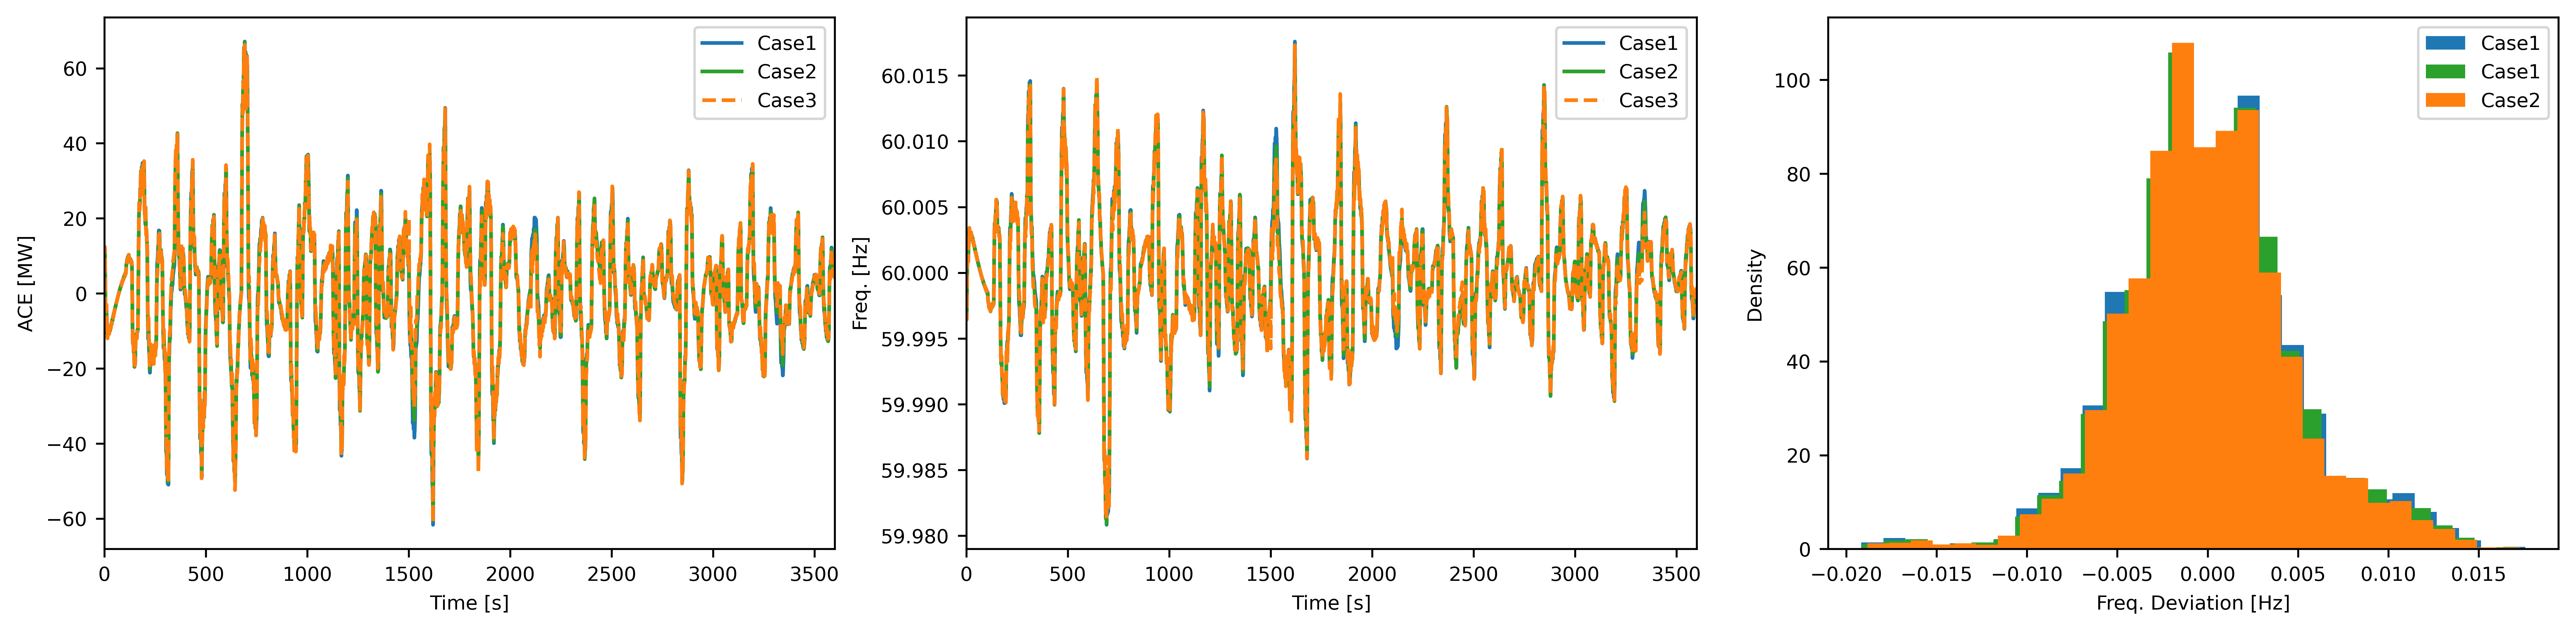

In [16]:
plt.style.use('ieee')
fig, ax = plt.subplots(1, 3, figsize=(18, 4))
plt.subplots_adjust(left=None, bottom=None, right=None,
                    top=None, wspace=0.18, hspace=None)
# ACE
outs.plot(x='Time', y='ACE', ax=ax[0], fig=fig, label='Case1', linestyle='-', color='tab:blue')
outh.plot(x='Time', y='ACE', ax=ax[0], fig=fig, label='Case2', linestyle='-', color='tab:green')
outf.plot(x='Time', y='ACE', ax=ax[0], fig=fig, label='Case3', linestyle='--', color='tab:orange')
# COI freq.
outs.plot(x='Time', y='freq', ax=ax[1], fig=fig, label='Case1', linestyle='-', color='tab:blue')
outh.plot(x='Time', y='freq', ax=ax[1], fig=fig, label='Case2', linestyle='-', color='tab:green')
outf.plot(x='Time', y='freq', ax=ax[1], fig=fig, label='Case3', linestyle='--', color='tab:orange')
# COI std.
outs.plot(x='Time', y='fd', kind='hist', density=True, bins=30, color='tab:blue',
          legend=False, linewidth=1, fig=fig, ax=ax[2], label='Case1')
outh.plot(x='Time', y='fd', kind='hist', density=True, bins=30, color='tab:green',
          legend=False, linewidth=1, fig=fig, ax=ax[2], label='Case1')
outf.plot(x='Time', y='fd', kind='hist', density=True, bins=30, color='tab:orange',
          legend=False, linewidth=1, fig=fig, ax=ax[2], label='Case2')
# outs.plot(x='Time', y='fd', kind='kde', color='tab:blue',
#           legend=False, fig=fig, ax=ax[2], label='Case1')
# outf.plot(x='Time', y='fd', kind='kde', color='tab:orange',
#           legend=False, fig=fig, ax=ax[2], label='Case2')

ax[0].set_xlim([0, 3600])
ax[1].set_xlim([0, 3600])
ax[0].set_xlabel('Time [s]')
ax[1].set_xlabel('Time [s]')
ax[0].set_ylabel('ACE [MW]')
ax[1].set_ylabel('Freq. [Hz]')
ax[2].set_xlabel('Freq. Deviation [Hz]')
ax[2].set_ylabel('Density')
ax[2].legend()

print(f"Freq. D.: case1={outs['fd'].std()}, case2={outh['fd'].std()}, case3={outf['fd'].std()}")
print(f"ACE D.: case1={outs['ACE'].std()}, case2={outh['ACE'].std()}, case3={outf['ACE'].std()}")

No SFR, if soc >= socd
SFR, soc < socd
incldue all EVs, 
delayed_time = (socd - soc) * Q / Pc / nc
  
total_charging_time (soc_init + soc_gap -> scod)


Text(0.5, 0.98, '')

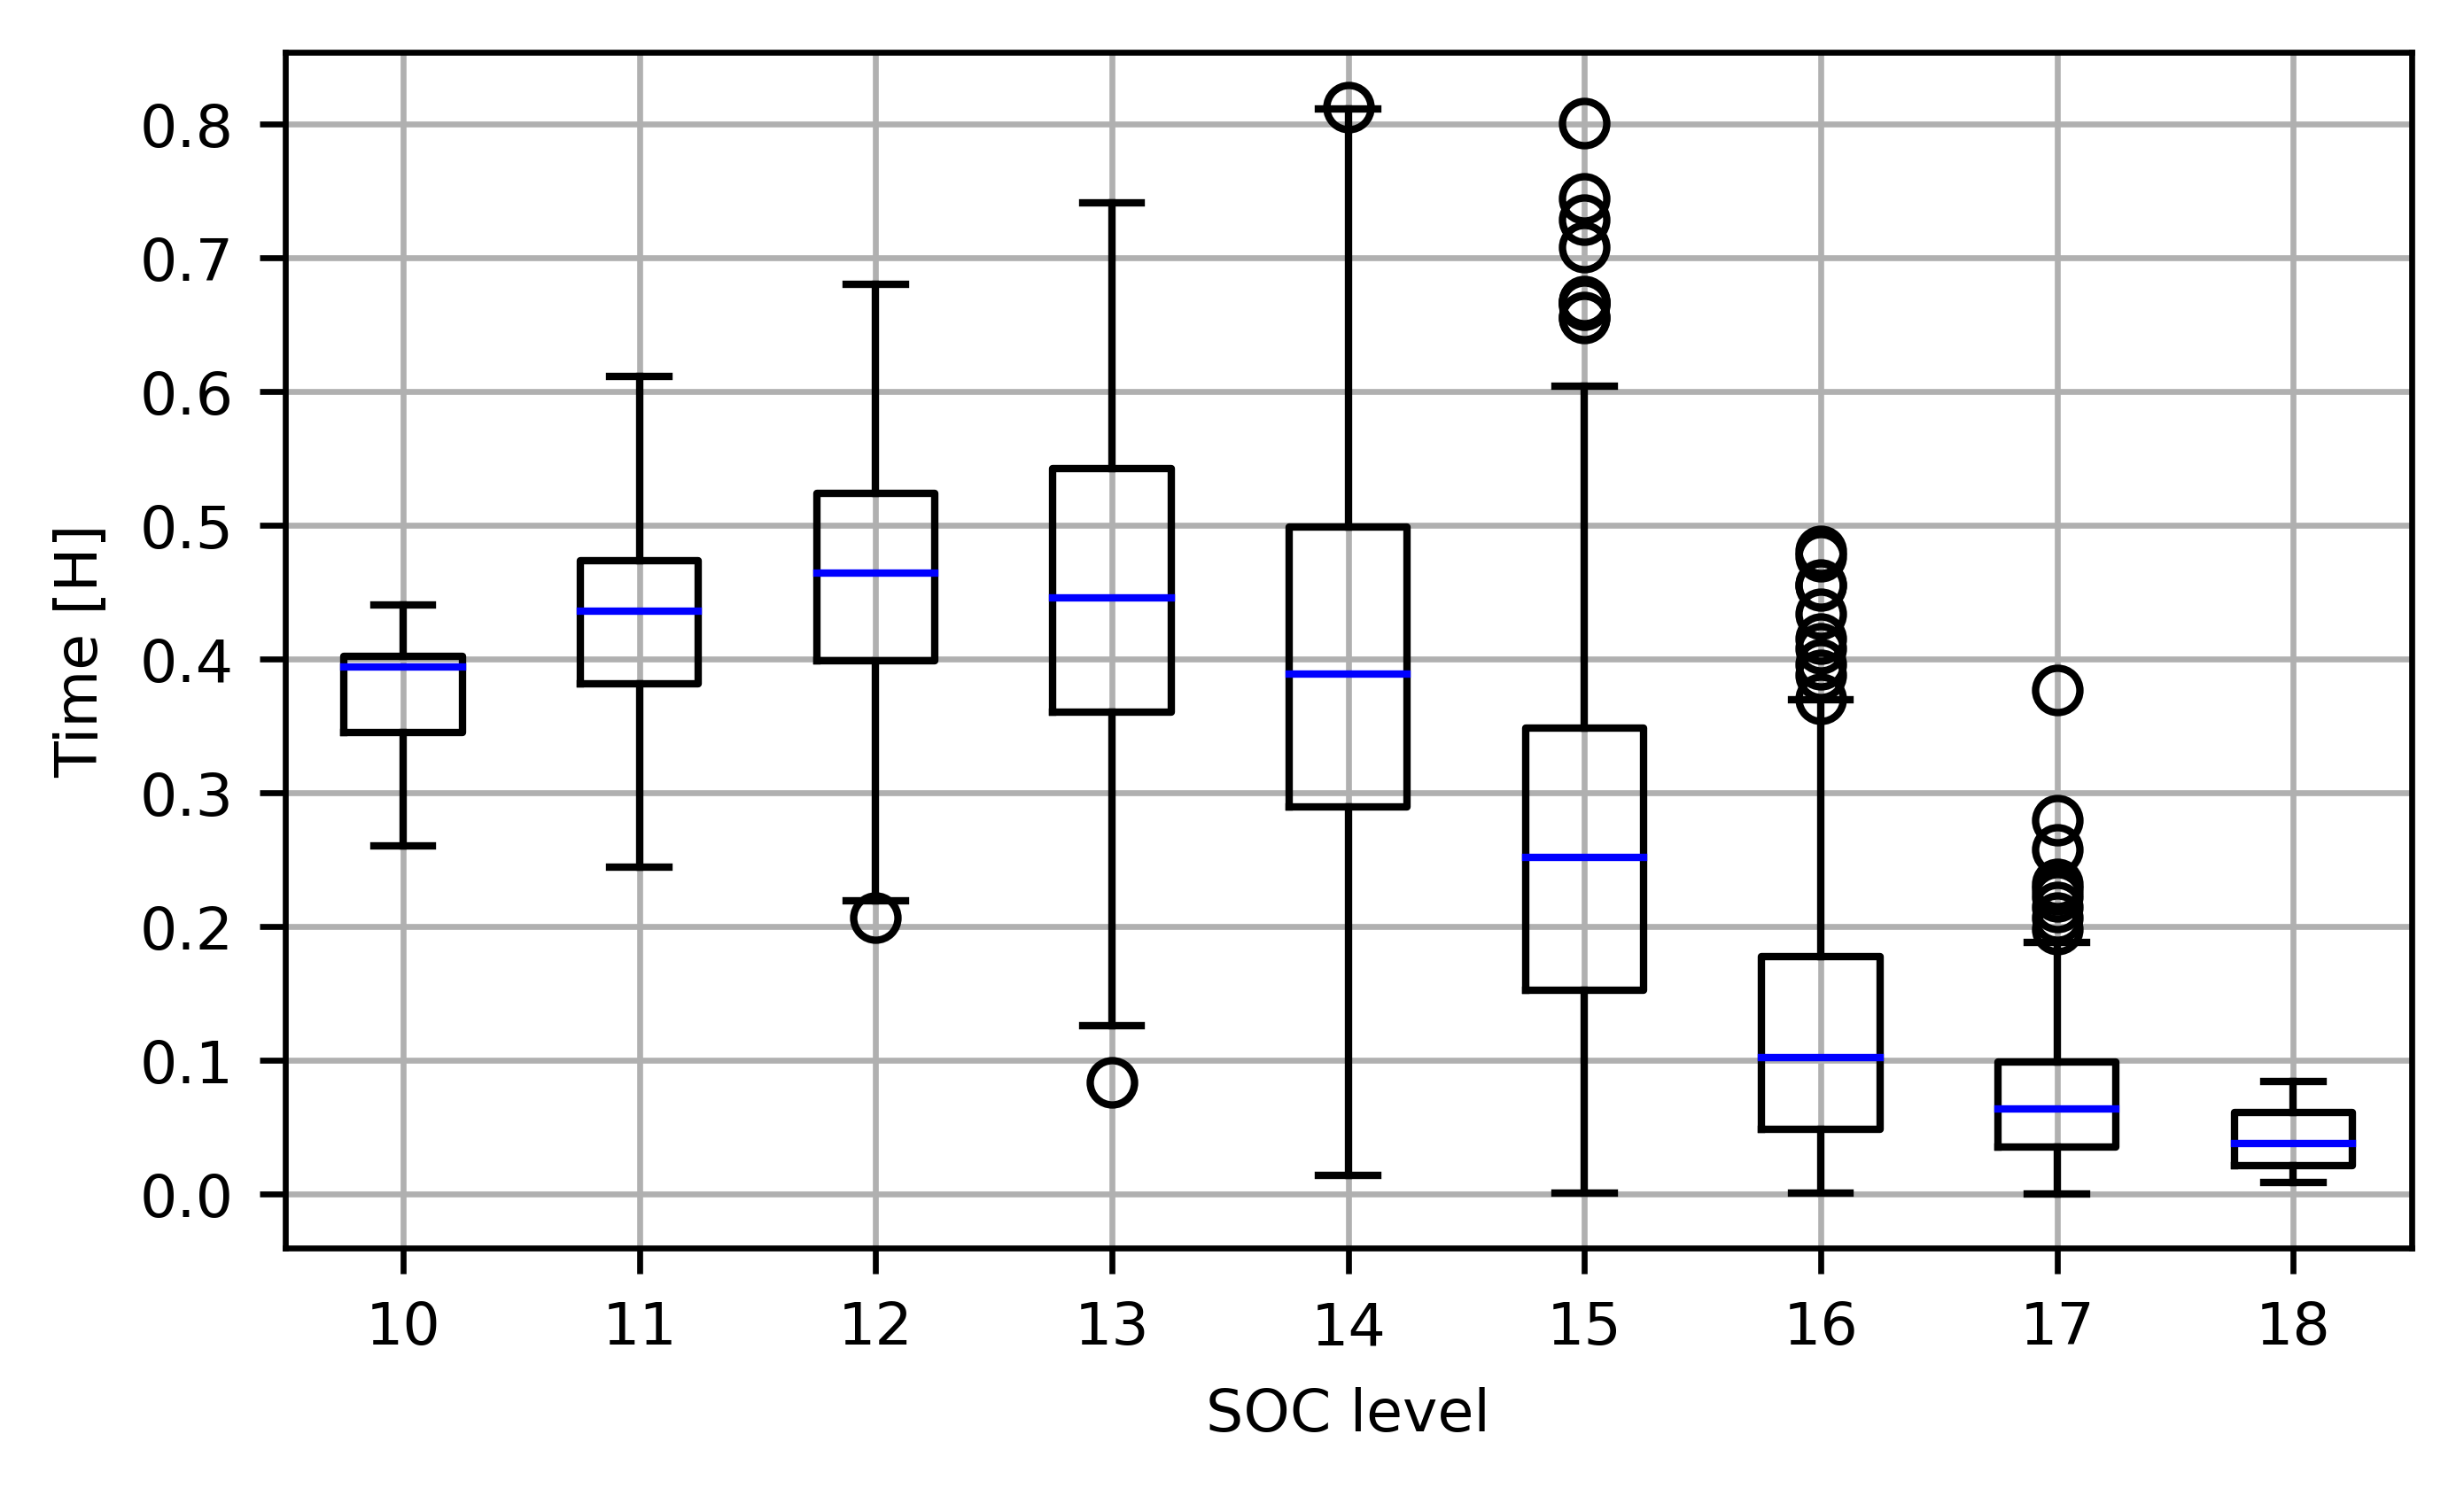

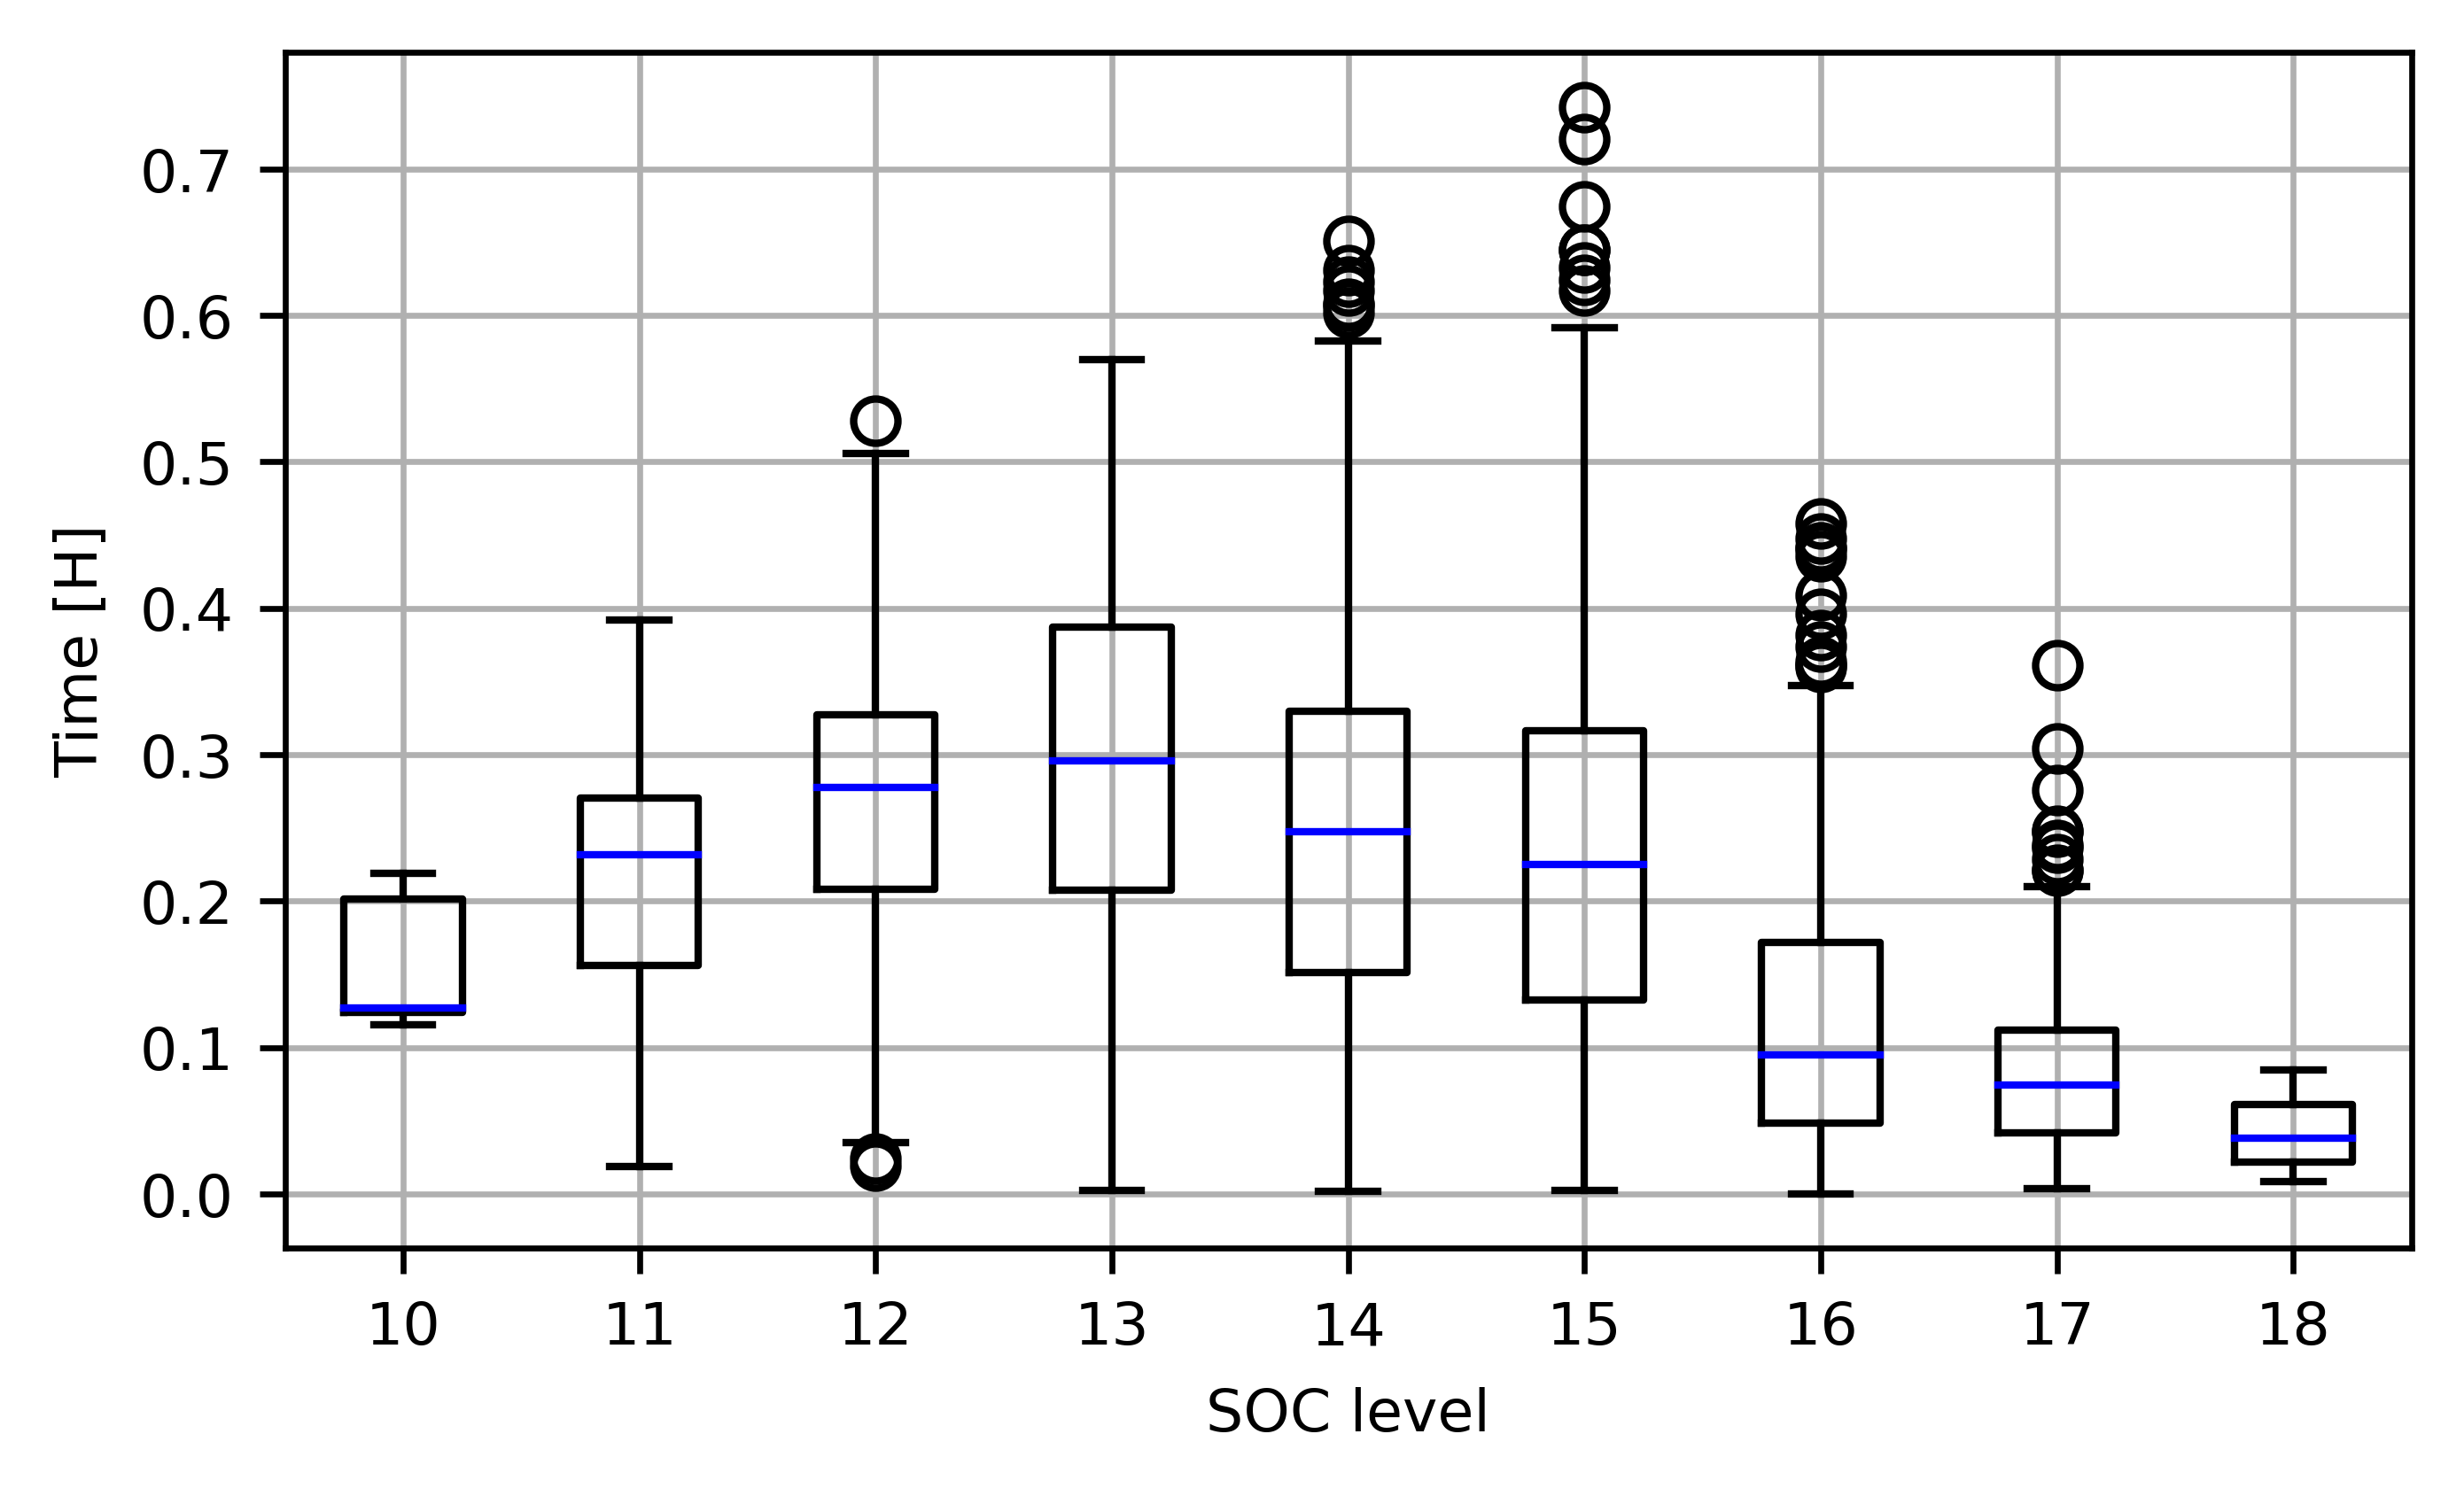

In [18]:
# If no AGC, how many EVs will charge to socd
num_ev_c2d = evds[(evds.soc >= evds.socd)].shape[0]
idx_evf_impacted = evds[(evds.soc >= evds.socd) & (evdf.soc < evdf.socd)].index
idx_evh_impacted = evds[(evds.soc >= evds.socd) & (evdh.soc < evdh.socd)].index

evif = evdf.iloc[idx_evf_impacted].copy()
evif['sx0'] = sse0.ev['sx'].iloc[idx_evf_impacted]
evif['soc0'] = sse0.ev['soc'].iloc[idx_evf_impacted]
evif['socs'] = evds['soc'].iloc[idx_evf_impacted]
evif['socf'] = evdf['soc'].iloc[idx_evf_impacted]
evif['socgap'] = evif['socd'] - evif['socf']
evif['dt'] = evif['socgap'] * evif['Q'] / evif['Pc'] / evif['nc']

evih = evdh.iloc[idx_evh_impacted].copy()
evih['sx0'] = sse0.ev['sx'].iloc[idx_evh_impacted]
evih['soc0'] = sse0.ev['soc'].iloc[idx_evh_impacted]
evih['socs'] = evds['soc'].iloc[idx_evh_impacted]
evih['socf'] = evdh['soc'].iloc[idx_evh_impacted]
evih['socgap'] = evih['socd'] - evih['socf']
evih['dt'] = evih['socgap'] * evih['Q'] / evih['Pc'] / evih['nc']
# evi[['soc0', 'socgap', 'Q', 'Pc', 'dt']]

plt.style.use('ieee')
ax = evif.boxplot(column=['dt'], by='sx0', figsize=(5, 3))
ax.set_title('')
ax.set_xlabel('SOC level')
ax.set_xticklabels([i+1 for i in evif.groupby('sx0').mean().index.tolist()])
ax.set_ylabel('Time [H]')
fig = ax.get_figure()
fig.suptitle('')

ax2 = evih.boxplot(column=['dt'], by='sx0', figsize=(5, 3))
ax2.set_title('')
ax2.set_xlabel('SOC level')
ax2.set_xticklabels([i+1 for i in evih.groupby('sx0').mean().index.tolist()])
ax2.set_ylabel('Time [H]')
fig2 = ax2.get_figure()
fig2.suptitle('')

In [39]:
evif[['sx0', 'socd', 'socf', 'socs', 'socgap']]

sx0      socd      socf      socs    socgap
0        6  0.836350  0.406235  0.410054  0.430116
1       16  0.826596  0.819643  0.960034  0.006953
2       19  0.812953  1.000000  1.000000 -0.187047
3       12  0.799929  0.682163  0.797119  0.117766
4       19  0.773551  0.962908  0.961767 -0.189357
...    ...       ...       ...       ...       ...
17382   19  0.814380  1.000000  1.000000 -0.185620
17383    7  0.791660  0.362738  0.363382  0.428922
17384    9  0.775908  0.594614  0.665940  0.181295
17385   16  0.792195  0.819815  0.809881 -0.027620
17386   19  0.829280  1.000000  1.000000 -0.170720

[17387 rows x 5 columns]

<AxesSubplot:xlabel='sx0'>

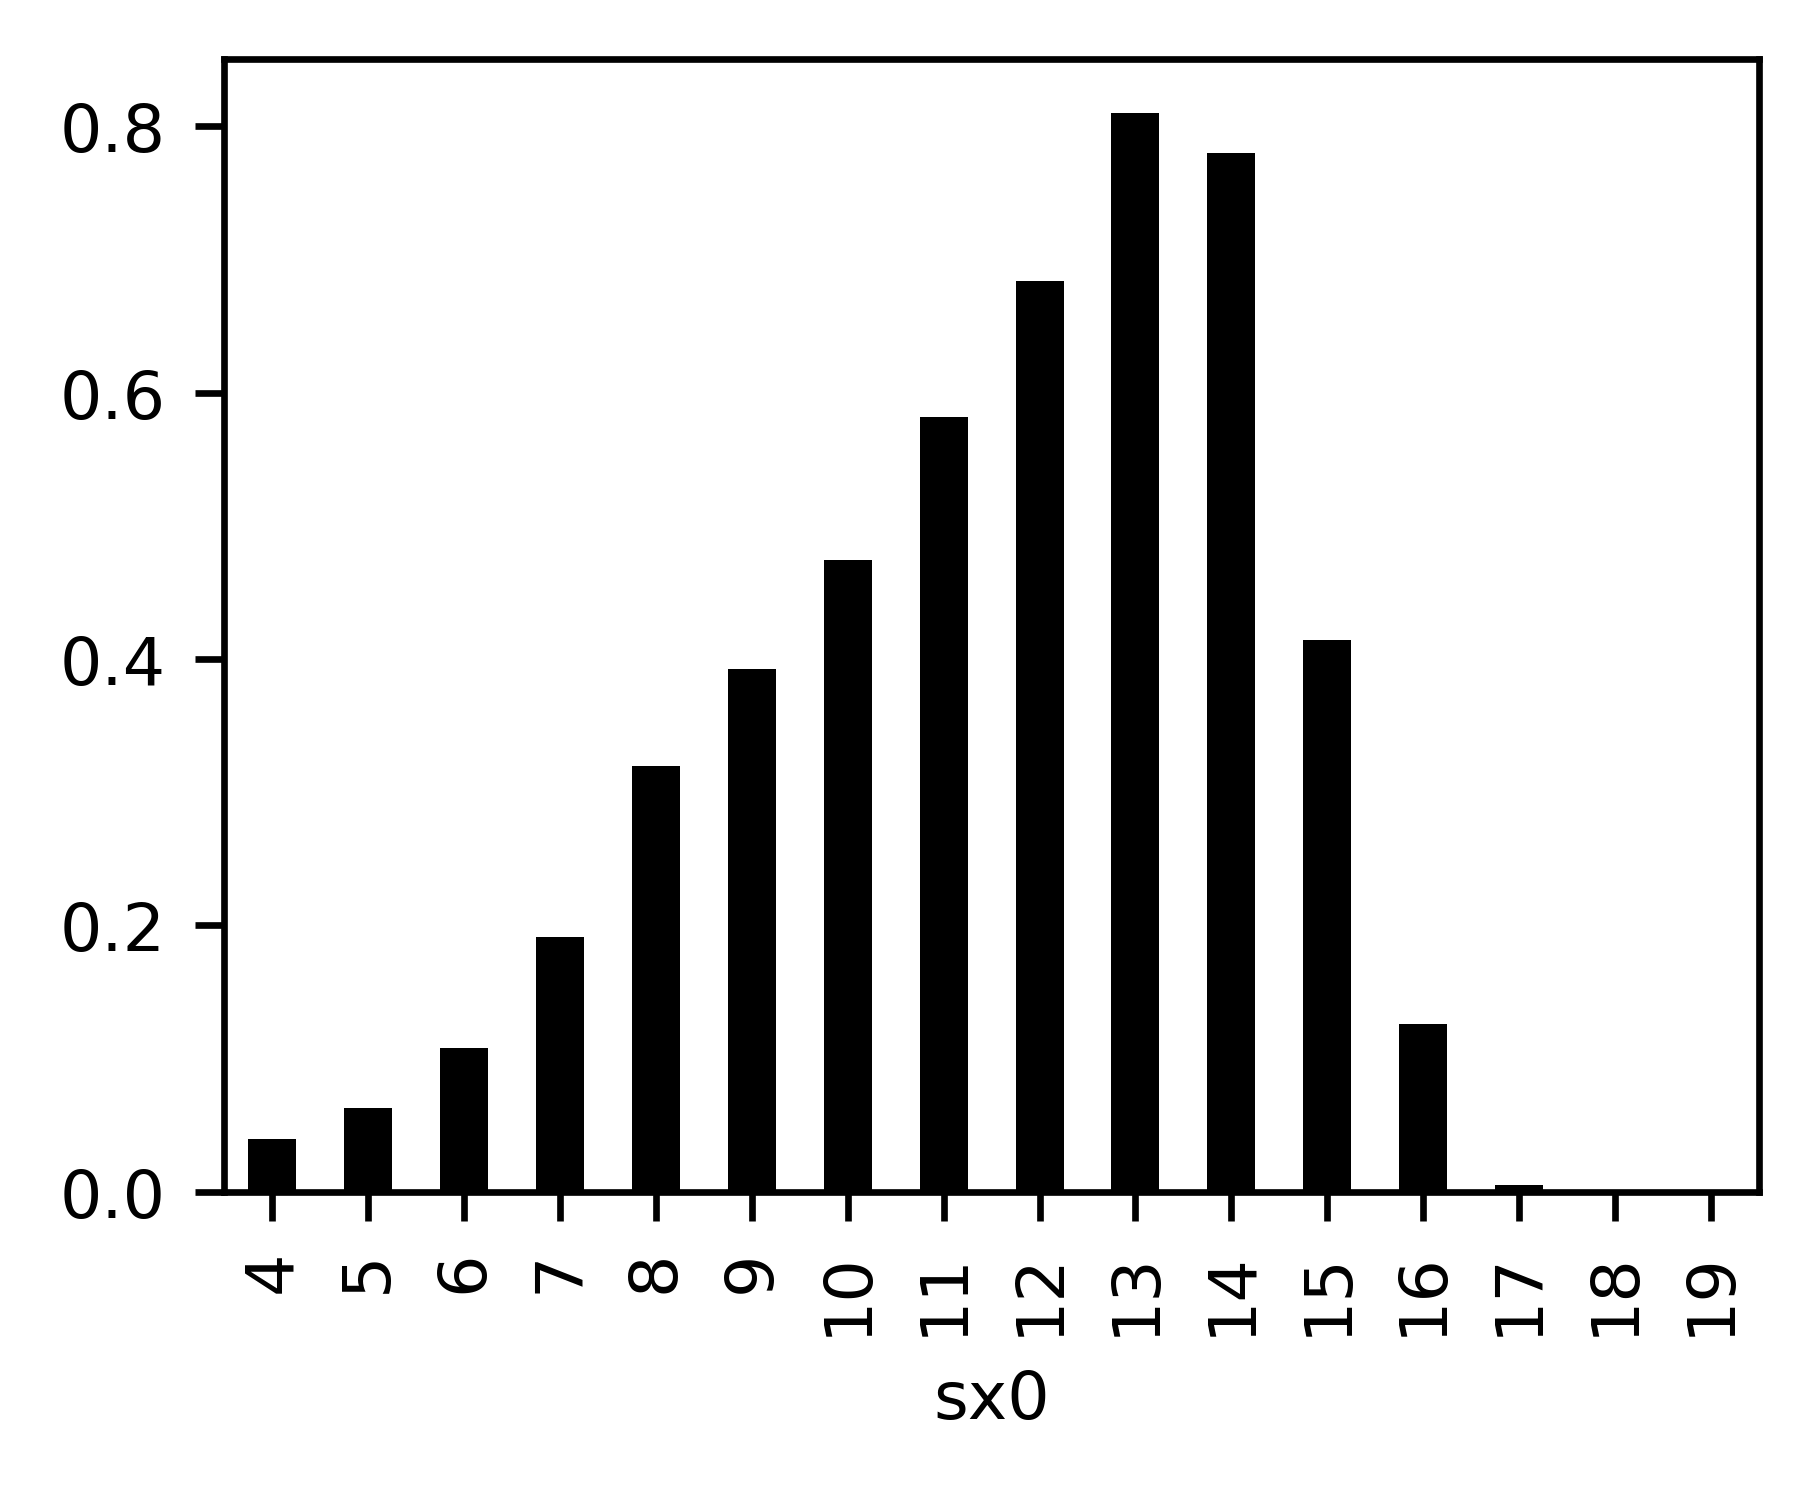

In [51]:
evif = evdf.copy()
evif['sx0'] = sse0.ev['sx']
evif['socf'] = evif['soc']
evif['socs'] = evds['soc']
evif['socgap'] = evif['socs'] - evif['socf']
evif['dt'] = evif['socgap'] * evif['Q'] / evif['Pc'] / evif['nc']
# set negative value to 0
evif['dt'][evif['dt']<0] = 0
# set demanded charged EV to 0
evif['dt'][evif['socf']>=evif['socd']] = 0
evif.groupby(by='sx0').mean()['dt'].plot.bar()

Text(0.5, 0.98, '')

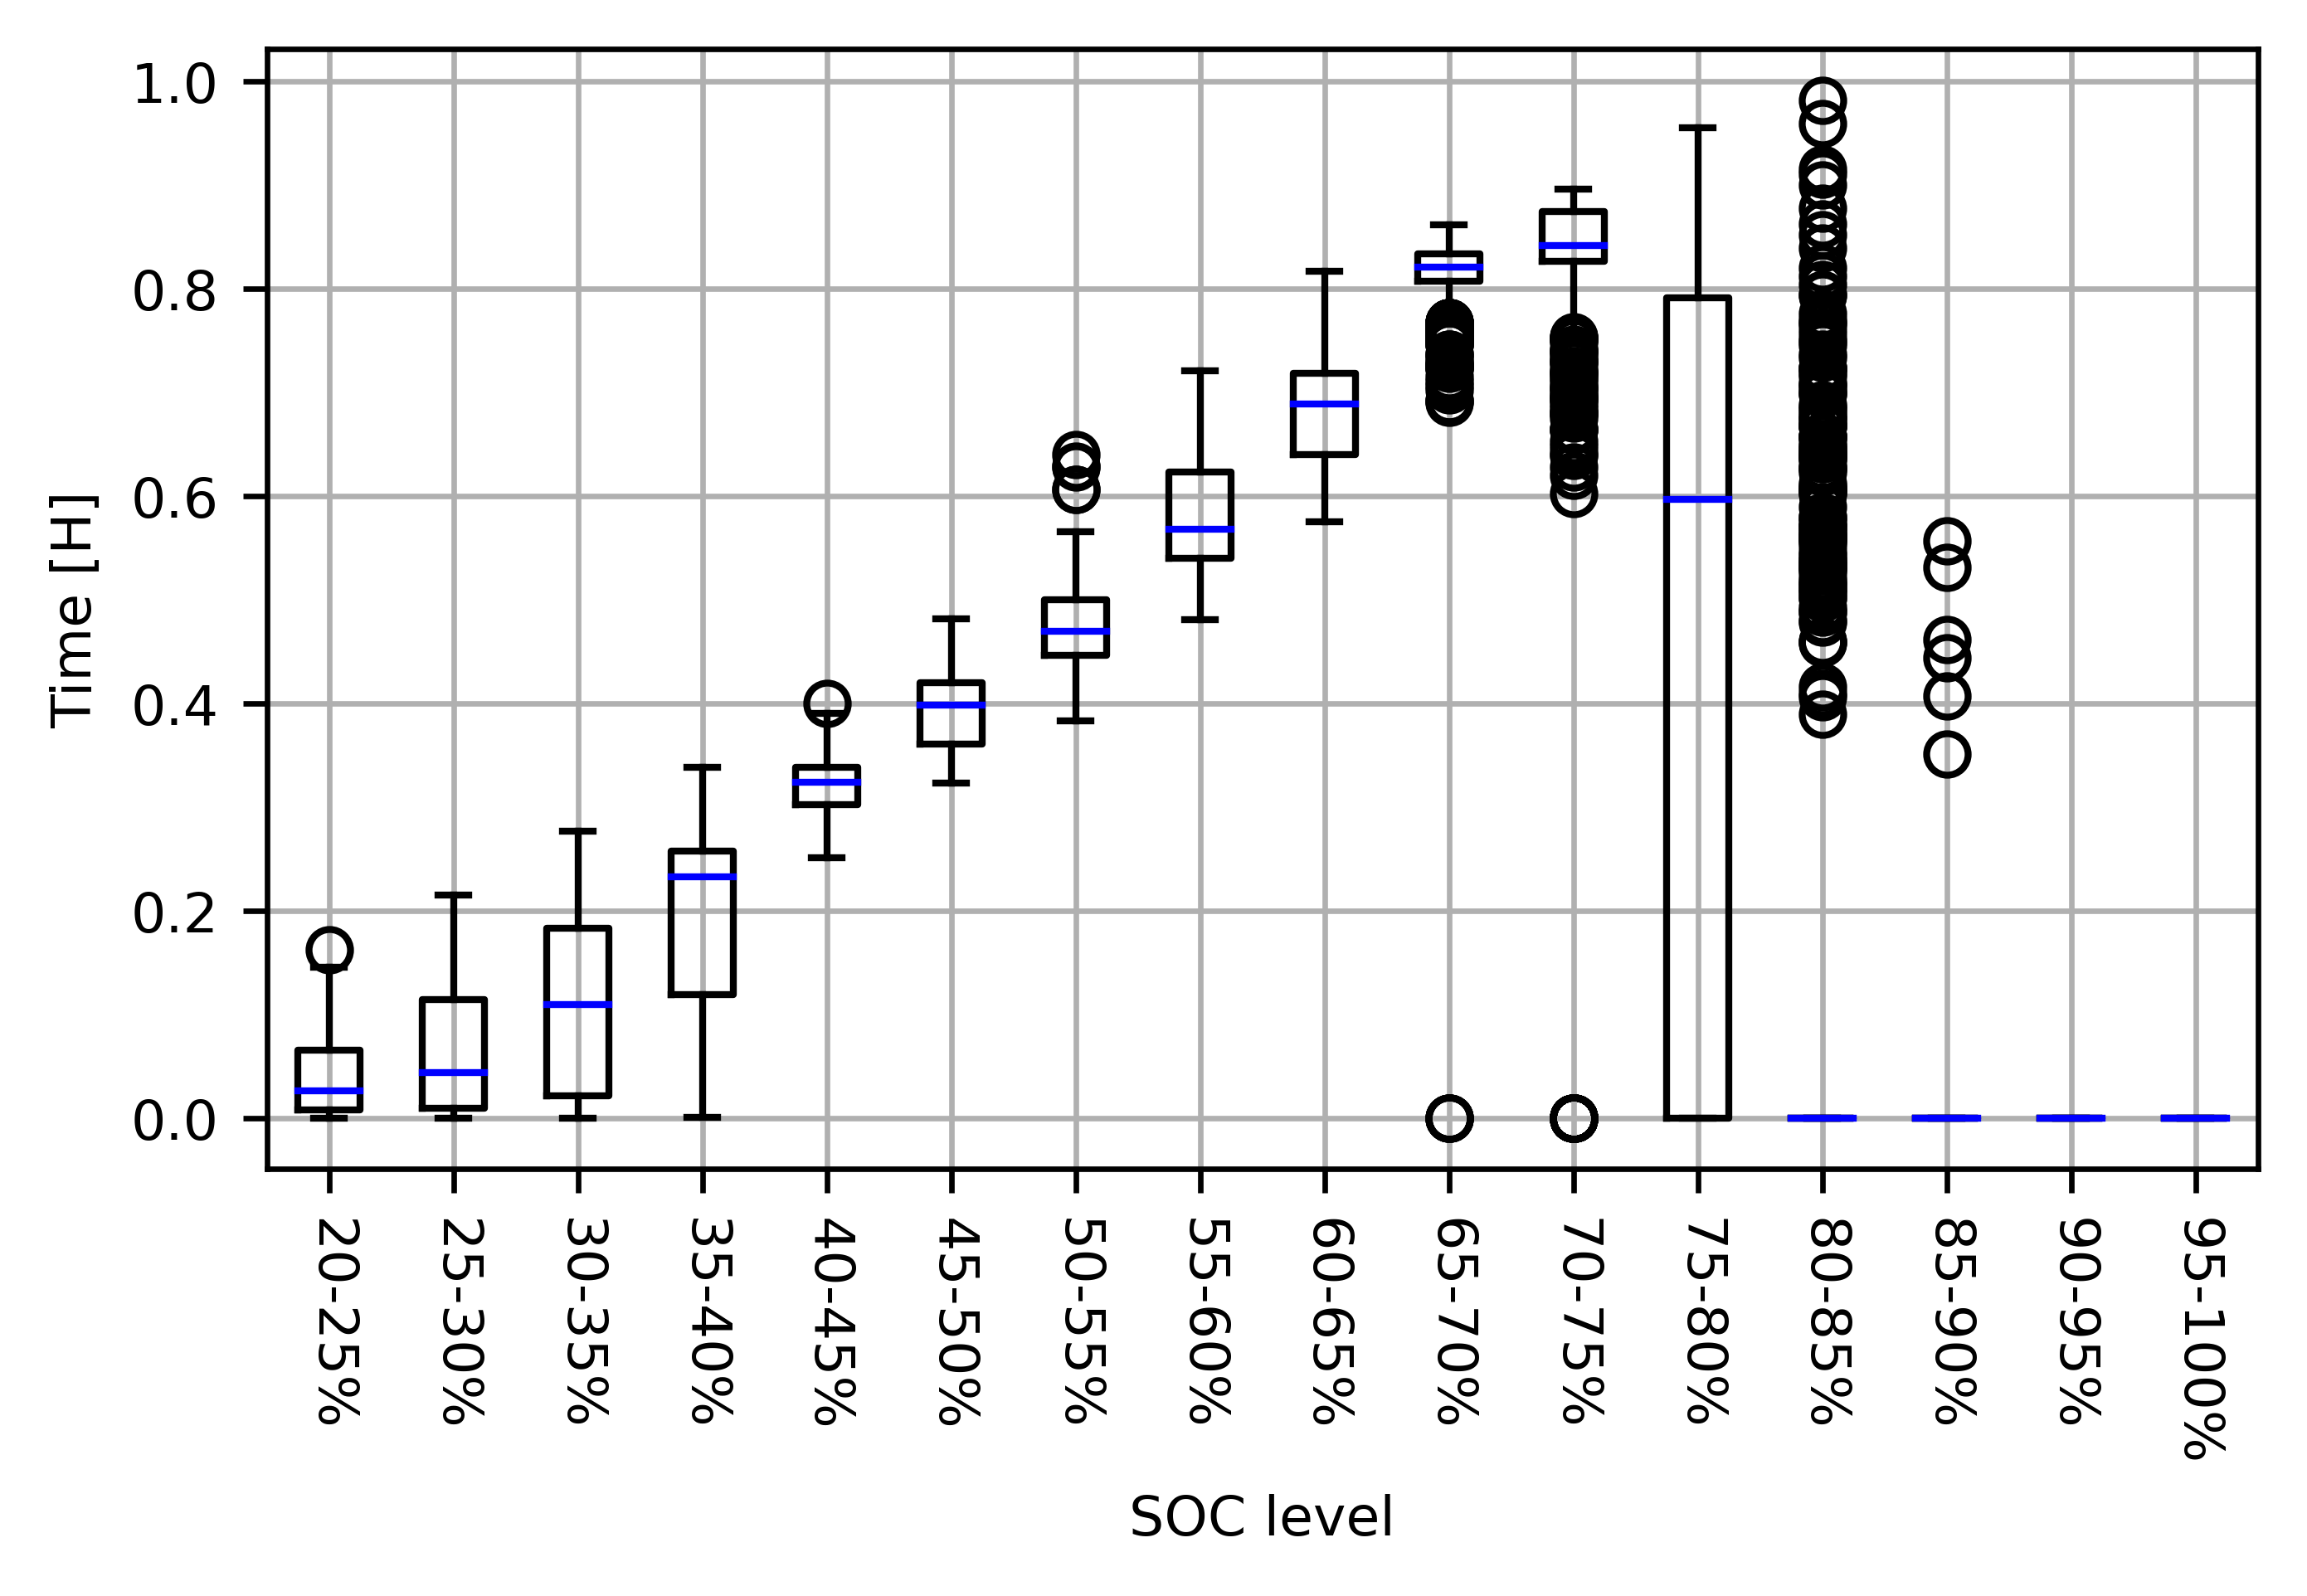

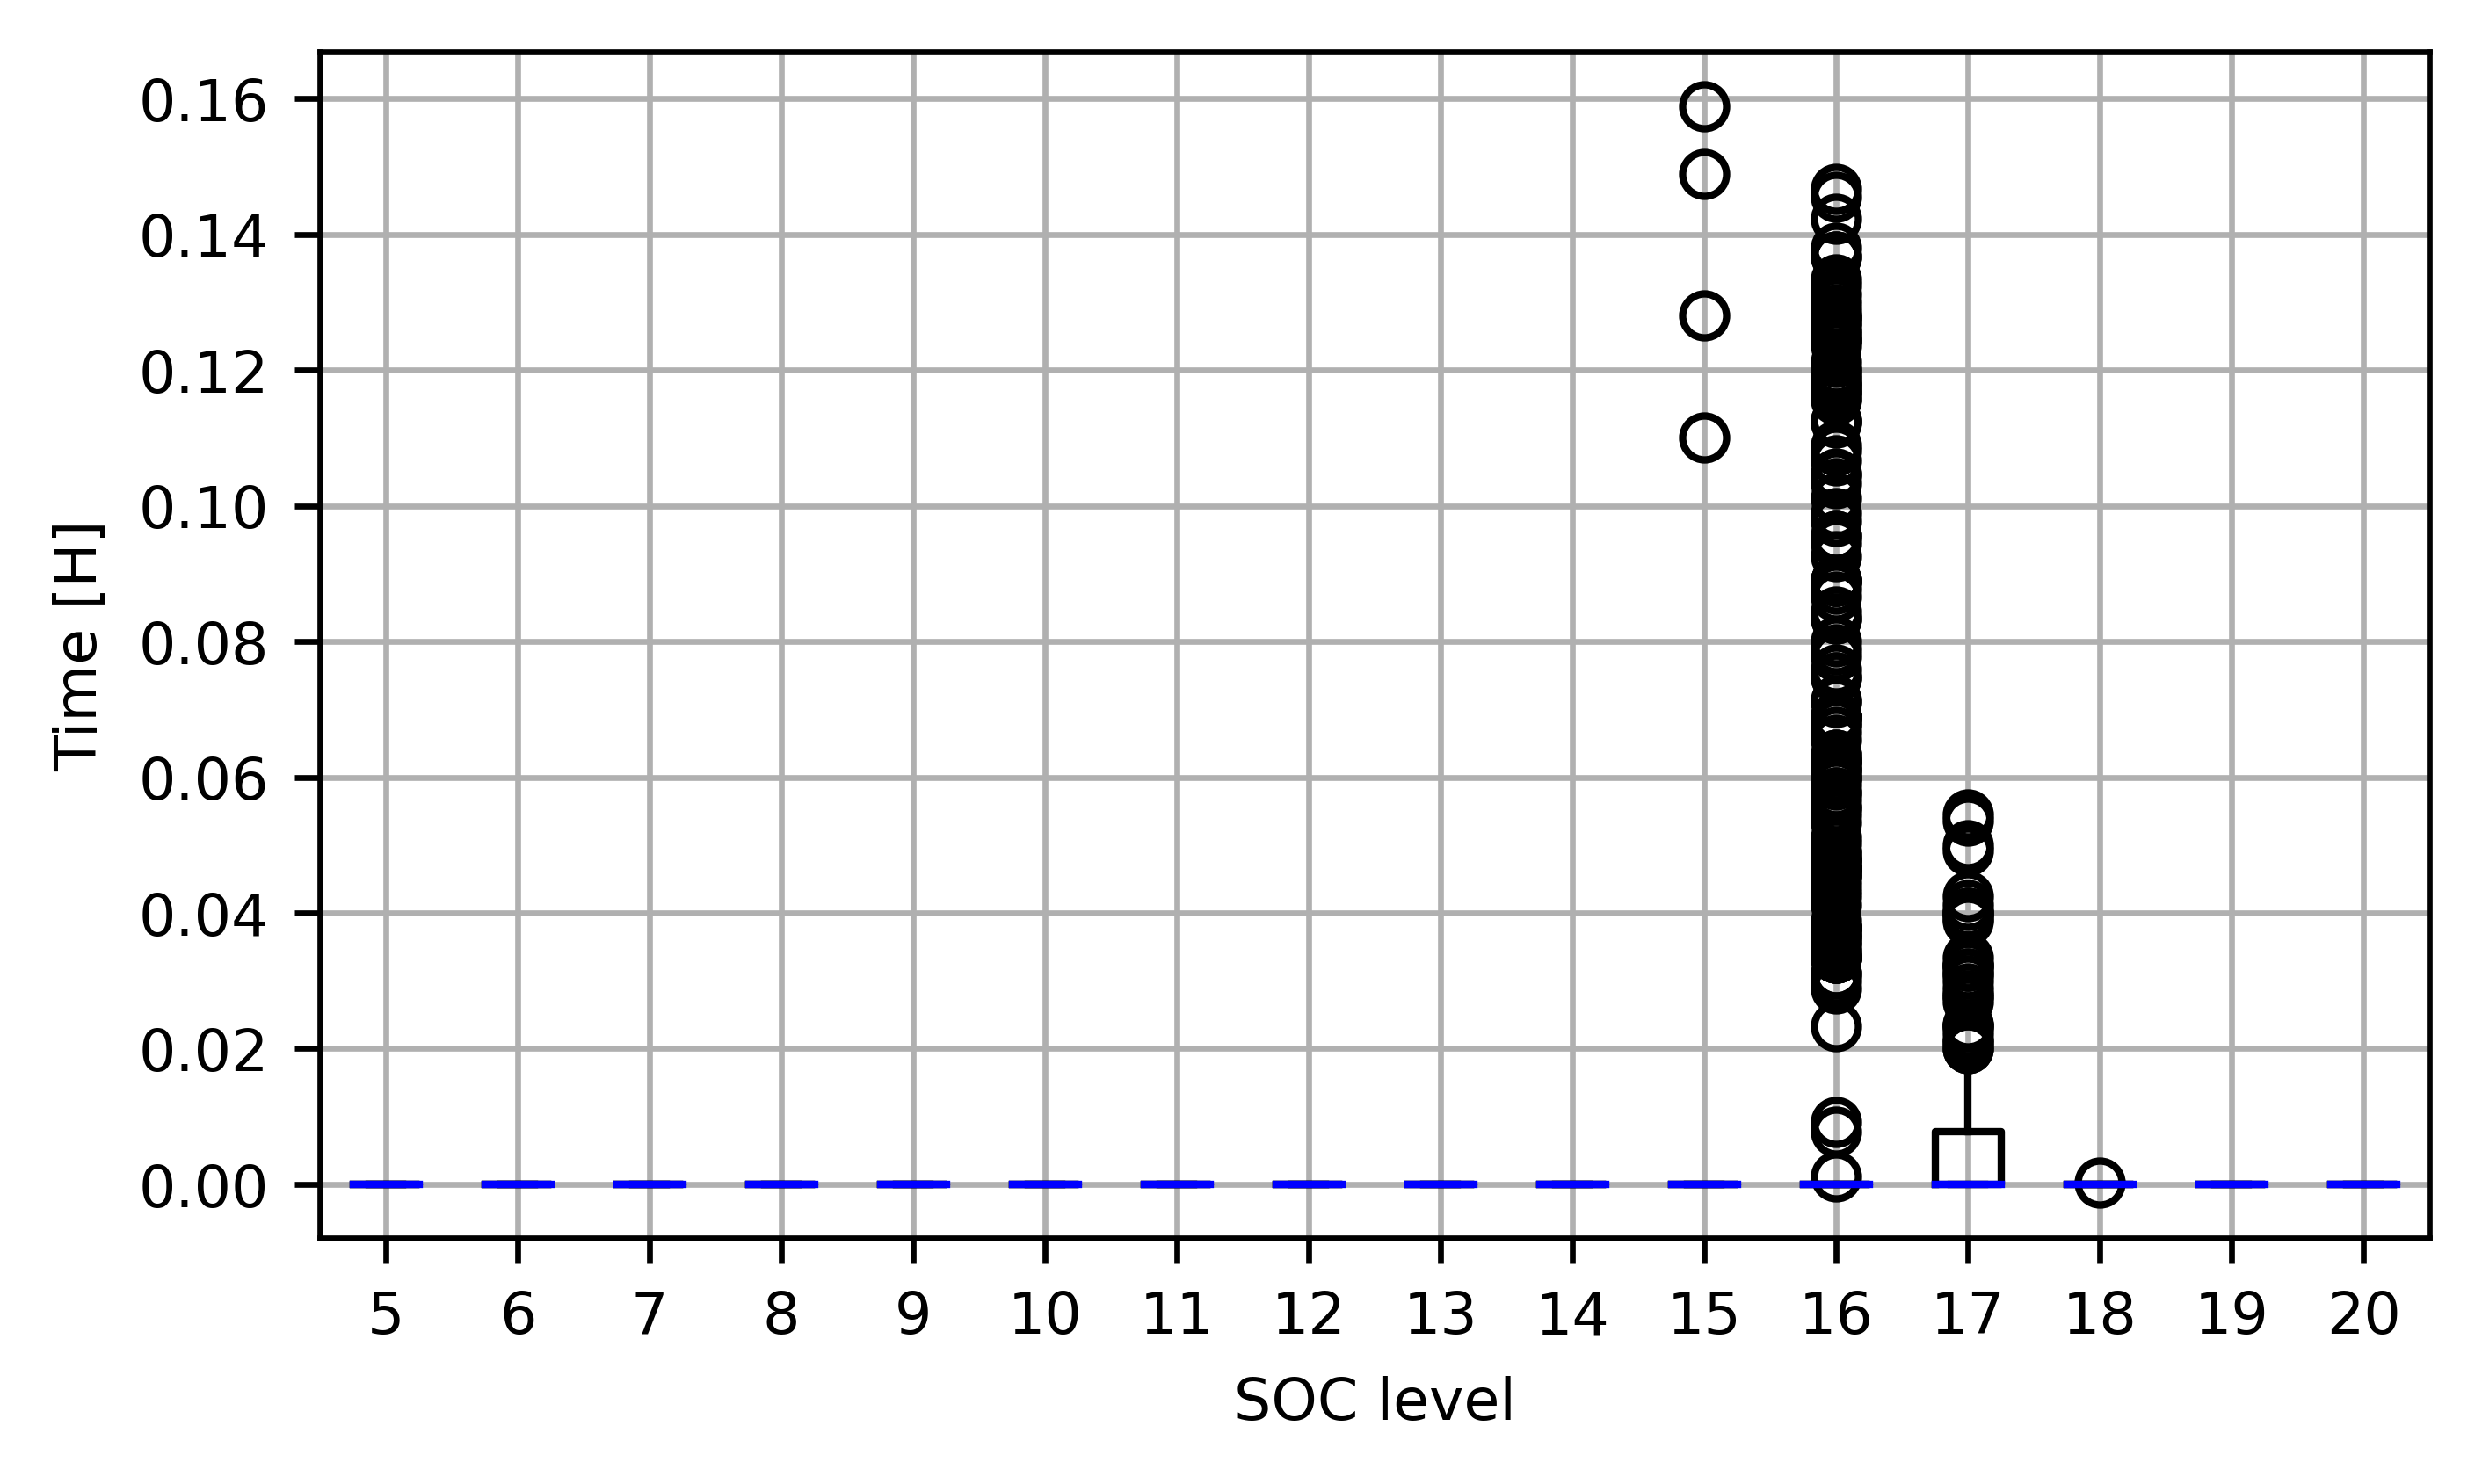

In [45]:
# Delayed time by participating SFR

evif = evdf.copy()
evif['sx0'] = sse0.ev['sx']
evif['socf'] = evif['soc']
evif['socs'] = evds['soc']
evif['socgap'] = evif['socs'] - evif['socf']
evif['dt'] = evif['socgap'] * evif['Q'] / evif['Pc'] / evif['nc']
# set negative value to 0
evif['dt'][evif['dt']<0] = 0
# set demanded charged EV to 0
evif['dt'][evif['socf']>=evif['socd']] = 0

evih = evdh.copy()
evih['sx0'] = sse0.ev['sx']
evih['soc0'] = sse0.ev['soc']
evih['socf'] = evdh['soc']
evih['socs'] = evds['soc']
evih['socgap'] = evih['soc'] - evih['socs']
evih['dt'] = evih['socgap'] * evih['Q'] / evih['Pc'] / evih['nc']
evih['dt'][evih['dt']<0] = 0

plt.style.use('ieee')
ax = evif.boxplot(column=['dt'], by='sx0', figsize=(5, 3))
ax.set_title('')
ax.set_xlabel('SOC level')
ax.set_xticklabels([f"{i*5}-{i*5+5}%" for i in evif.groupby('sx0').mean().index.tolist()],
                   rotation = 270)
ax.set_ylabel('Time [H]')
fig = ax.get_figure()
fig.suptitle('')

ax2 = evih.boxplot(column=['dt'], by='sx0', figsize=(5, 3))
ax2.set_title('')
ax2.set_xlabel('SOC level')
ax2.set_xticklabels([i+1 for i in evif.groupby('sx0').mean().index.tolist()])
ax2.set_ylabel('Time [H]')
fig2 = ax2.get_figure()
fig2.suptitle('')

In [ ]:
evif[['soc0', 'socf', 'socd', 'socgap', 'Q', 'Pc', 'dt', 'nc']]

In [ ]:
import matplotlib.font_manager

In [ ]:
import matplotlib.font_manager

In [ ]:
plt.style.use('ieee')
fig, ax = plt.subplots(1, 3, figsize=(18, 4))
plt.subplots_adjust(left=None, bottom=None, right=None,
                    top=None, wspace=0.18, hspace=None)

ax[2].plot(3600*(np.array(evs.time)-18), evs.Prc, label='Case1 EV AGC response', linestyle='-', color='tab:blue')
ax[2].plot(3600*(np.array(evs.time)-18), evh.Prc, label='Case2 EV AGC response', linestyle='-', color='tab:green')
ax[2].plot(3600*(np.array(evs.time)-18), evf.Prc, label='Case3 EV AGC response', linestyle='-', color='tab:orange')
ax[2].plot(3600*(np.array(evs.time)-18), evs.Pt, label='Case1 EV total output', linestyle='--', color='tab:blue')
ax[2].plot(3600*(np.array(evs.time)-18), evh.Pt, label='Case2 EV total output', linestyle='--', color='tab:green')
ax[2].plot(3600*(np.array(evs.time)-18), evf.Pt, label='Case3 EV total output', linestyle='--', color='tab:orange')
ax[2].legend()
ax[2].set_xlim([0, 3600])
ax[2].set_xlabel('Time [s]')
ax[2].set_ylabel('EV output power [MW]')

sfrs.plot(x='time', y='ace', ax=ax[0], fig=fig, label='Case1', linestyle='-', color='tab:blue')
sfrh.plot(x='time', y='ace', ax=ax[0], fig=fig, label='Case2', linestyle='-', color='tab:green')
sfrf.plot(x='time', y='ace', ax=ax[0], fig=fig, label='Case3', linestyle='-', color='tab:orange')
sfrs.plot(x='time', y='up', ax=ax[0], fig=fig, label='RegUp capacity', linestyle='--', color='black')
sfrs.plot(x='time', y='dn', ax=ax[0], fig=fig, label='RegDn capacity', linestyle='--', color='black')
ax[0].set_xlim([0, 3600])
ax[0].set_xlabel('Time [s]')
ax[0].set_ylabel('Total AGC signal [MW]')

outs.plot(x='Time', y='paux9', ax=ax[1], fig=fig, label='Case1', linestyle='-', color='tab:blue')
outh.plot(x='Time', y='paux9', ax=ax[1], fig=fig, label='Case2', linestyle='-', color='tab:green')
outf.plot(x='Time', y='paux9', ax=ax[1], fig=fig, label='Case3', linestyle='-', color='tab:orange')
ax[1].set_xlim([0, 3600])
ax[1].set_xlabel('Time [s]')
ax[1].set_ylabel('G3 AGC response [MW]')

In [ ]:
plt.style.use('ieee')

bu_df = pd.read_csv('cosim_18_S_bu.csv')
bd_df = pd.read_csv('cosim_18_S_bd.csv')

color = ['tab:blue', 'yellow', 'tab:green',
         'tab:red', 'tab:purple', 'tab:brown',
         'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan', 'tab:orange']

figs, axes = plt.subplots(1, 2, figsize=(10.5, 3))
plt.subplots_adjust(left=None, bottom=None, right=None,
                    top=None, wspace=0.38, hspace=None)
new_cols = ['PV_1', 'PV_2', 'PV_3', 'PV_4', 'PV_5', 'PV_6',
            'PV_7', 'PV_8', 'PV_9', 'Slack_10', 'PV_10']
bu_df[new_cols].plot.bar(stacked=True, ax=axes[0], legend=False, color=color)
bd_df[new_cols].plot.bar(stacked=True, ax=axes[1], legend=False, color=color)

for ax in axes:
    ax.tick_params(axis='x', labelrotation = 0)
    ax.set_ylim([0, 1])
    ax.set_yticklabels([f'{np.round(i*100,0)}%' for i in np.arange(0, 1.1, 0.2)])
    ax.set_xticklabels([i for i in range(1,13,1)])
    ax.set_xlabel('RTED interval')
axes[0].set_title('(a) Case 1: RegUp balancing factor')
axes[1].set_title('(b) Case 1: RegDn balancing factor')
lines_labels = [ax.get_legend_handles_labels() for ax in axes]
lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]
line_plot = lines[0:11]
line_plot.reverse()
label_g = ['G1', 'G2', 'G3', 'G4', 'G5', 'G6', 'G7', 'G8', 'G9', 'G10', 'EV']
label_g.reverse()
figs.legend(line_plot, label_g, loc='center')

In [ ]:
plt.style.use('ieee')

bu_df = pd.read_csv('cosim_18_H_bu.csv')
bd_df = pd.read_csv('cosim_18_H_bd.csv')

color = ['tab:blue', 'yellow', 'tab:green',
         'tab:red', 'tab:purple', 'tab:brown',
         'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan', 'tab:orange']

figs, axes = plt.subplots(1, 2, figsize=(10.5, 3))
plt.subplots_adjust(left=None, bottom=None, right=None,
                    top=None, wspace=0.38, hspace=None)
new_cols = ['PV_1', 'PV_2', 'PV_3', 'PV_4', 'PV_5', 'PV_6',
            'PV_7', 'PV_8', 'PV_9', 'Slack_10', 'PV_10']
bu_df[new_cols].plot.bar(stacked=True, ax=axes[0], legend=False, color=color)
bd_df[new_cols].plot.bar(stacked=True, ax=axes[1], legend=False, color=color)

for ax in axes:
    ax.tick_params(axis='x', labelrotation = 0)
    ax.set_ylim([0, 1])
    ax.set_yticklabels([f'{np.round(i*100,0)}%' for i in np.arange(0, 1.1, 0.2)])
    ax.set_xticklabels([i for i in range(1,13,1)])
    ax.set_xlabel('RTED interval')
axes[0].set_title('(c) Case 2: RegUp balancing factor')
axes[1].set_title('(d) Case 2: RegDn balancing factor')
lines_labels = [ax.get_legend_handles_labels() for ax in axes]
lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]
line_plot = lines[0:11]
line_plot.reverse()
label_g = ['G1', 'G2', 'G3', 'G4', 'G5', 'G6', 'G7', 'G8', 'G9', 'G10', 'EV']
label_g.reverse()
figs.legend(line_plot, label_g, loc='center')

In [ ]:
plt.style.use('ieee')

bu_df = pd.read_csv('cosim_18_F_bu.csv')
bd_df = pd.read_csv('cosim_18_F_bd.csv')

color = ['tab:blue', 'yellow', 'tab:green',
         'tab:red', 'tab:purple', 'tab:brown',
         'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan', 'tab:orange']

figs, axes = plt.subplots(1, 2, figsize=(10.5, 3))
plt.subplots_adjust(left=None, bottom=None, right=None,
                    top=None, wspace=0.38, hspace=None)
new_cols = ['PV_1', 'PV_2', 'PV_3', 'PV_4', 'PV_5', 'PV_6',
            'PV_7', 'PV_8', 'PV_9', 'Slack_10', 'PV_10']
bu_df[new_cols].plot.bar(stacked=True, ax=axes[0], legend=False, color=color)
bd_df[new_cols].plot.bar(stacked=True, ax=axes[1], legend=False, color=color)

for ax in axes:
    ax.tick_params(axis='x', labelrotation = 0)
    ax.set_ylim([0, 1])
    ax.set_yticklabels([f'{np.round(i*100,0)}%' for i in np.arange(0, 1.1, 0.2)])
    ax.set_xticklabels([i for i in range(1,13,1)])
    ax.set_xlabel('RTED interval')
axes[0].set_title('(c) Case 3: RegUp balancing factor')
axes[1].set_title('(d) Case 3: RegDn balancing factor')
lines_labels = [ax.get_legend_handles_labels() for ax in axes]
lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]
line_plot = lines[0:11]
line_plot.reverse()
label_g = ['G1', 'G2', 'G3', 'G4', 'G5', 'G6', 'G7', 'G8', 'G9', 'G10', 'EV']
label_g.reverse()
figs.legend(line_plot, label_g, loc='center')